# SIPSA Project
##### Developed by Sébastien Lozano-Forero



In [6]:
import sys
from pathlib import Path

# Add the 'utils' directory to the system path so we can import from it
sys.path.append(str(Path().resolve().parent / 'utils'))
sys.path.append(str(Path().resolve().parent / 'src'))

import pandas as pd
from aws_utils import DataPipelineManager
from visualization_utils import lineplot_per_category, lineplot_per_category_grid
from DataIngestor import DataIngestor

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import accuracy_score

## Exploratory Data Analysis

In [8]:
run = DataPipelineManager()

In [62]:
run.get_files_tracker_from_s3()

,file,link,date_added,rds_load
0,week_1_Anexo_Bol_Semanal_SIPSA_Noviembre_16_20...,NaN,NaN,yes
1,week_2_Anexo_Bol_Semanal_SIPSA_Noviembre_23_20...,NaN,NaN,yes
2,week_3_Anexo_Bol_Semanal_SIPSA_Noviembre_24_20...,NaN,NaN,yes
3,week_4_Anexo_Bol_Semanal_SIPSA_Diciembre_1_201...,NaN,NaN,yes
4,week_5_Anexo_Bol_Semanal_SIPSA_Diciembre_8_201...,NaN,NaN,yes
...,...,...,...,...
619,week_5_anex-SIPSASemanal-27ene-02feb-2024.xlsx,NaN,NaN,yes
620,week_6_anex-SIPSASemanal-03feb-09feb-2024.xlsx,NaN,NaN,yes
621,week_7_anex-SIPSASemanal-10feb-16feb-2024.xlsx,NaN,NaN,yes
622,week_8_anex-SIPSASemanal-17feb-23feb-2024.xlsx,NaN,NaN,yes


In [15]:
run.log_files_manager(log_prefix = 'app_logs', log_file = 'app_logs/sipsapp_usage_11_28_2024.log')

,timestamp,level,message
0,"2024-11-28 10:36:35,546",INFO,App initialized.
1,"2024-11-28 10:36:37,241",INFO,Forecasting food prices used for beef_boot in ...
2,"2024-11-28 10:36:40,597",INFO,Uploading log file to S3 bsucket s3.ServiceRe...
3,                                              ...,INFO,App initialized.
4,"2024-11-28 10:36:37,241",INFO,Forecasting food prices used for beef_boot in ...
5,"2024-11-28 10:36:40,597",INFO,Uploading log file to S3 bsucket s3.ServiceRe...
6,"2024-11-28 10:36:40,597",INFO,Uploading log file to S3 bsucket s3.ServiceRe...
7,"2024-11-28 10:36:40,597",INFO,Uploading log file to S3 bsucket s3.ServiceRe...
8,                                              ...,INFO,App initialized.
9,"2024-11-28 10:36:37,241",INFO,Forecasting food prices used for beef_boot in ...


In [63]:
query = """
    SELECT semana_no, anho, count(*) as record_count FROM product_prices 
    GROUP BY semana_no, anho;
"""

In [64]:
df = run.queries_on_rds(query = query)

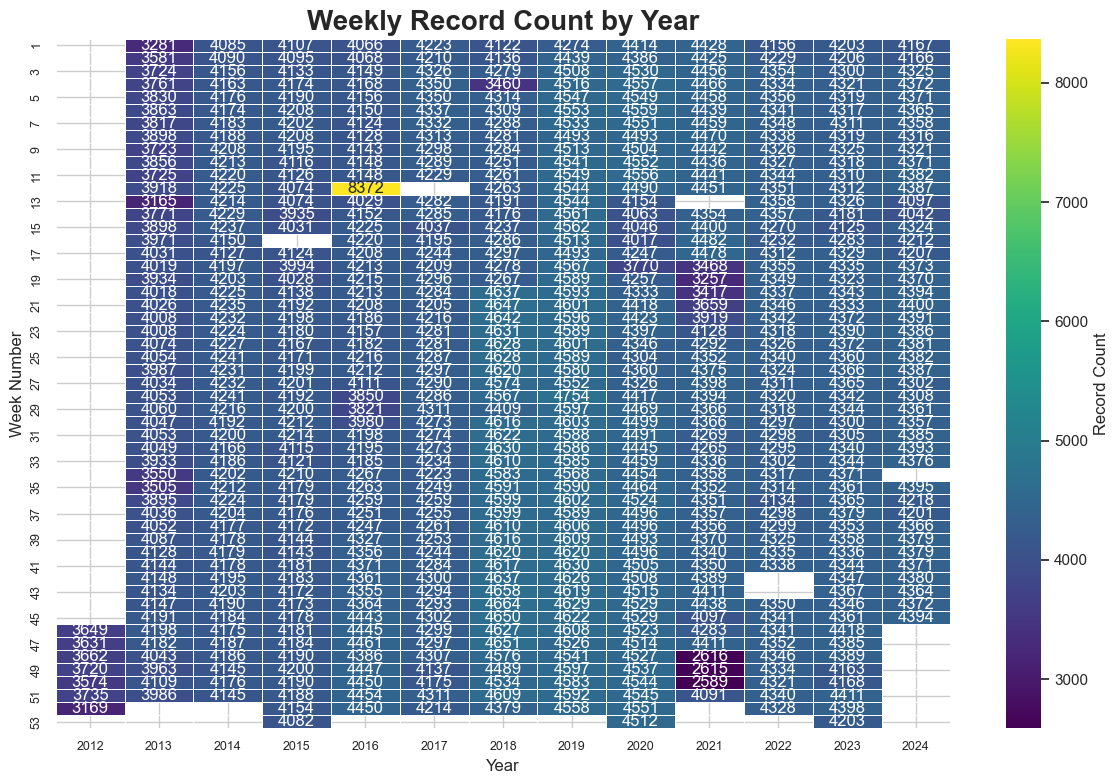

In [65]:
df_pivot = df.pivot(index='semana_no', columns='anho', values='record_count')

# setting plot size
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# heatmap to show the record counts over the weeks
ax = sns.heatmap(df_pivot, 
                 annot=True, 
                 fmt='g', 
                 cmap='viridis', 
                 linewidths=0.5, 
                 cbar_kws={'label': 'Record Count'})

# mugre
plt.title('Weekly Record Count by Year', fontsize=20, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Week Number', fontsize=12)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

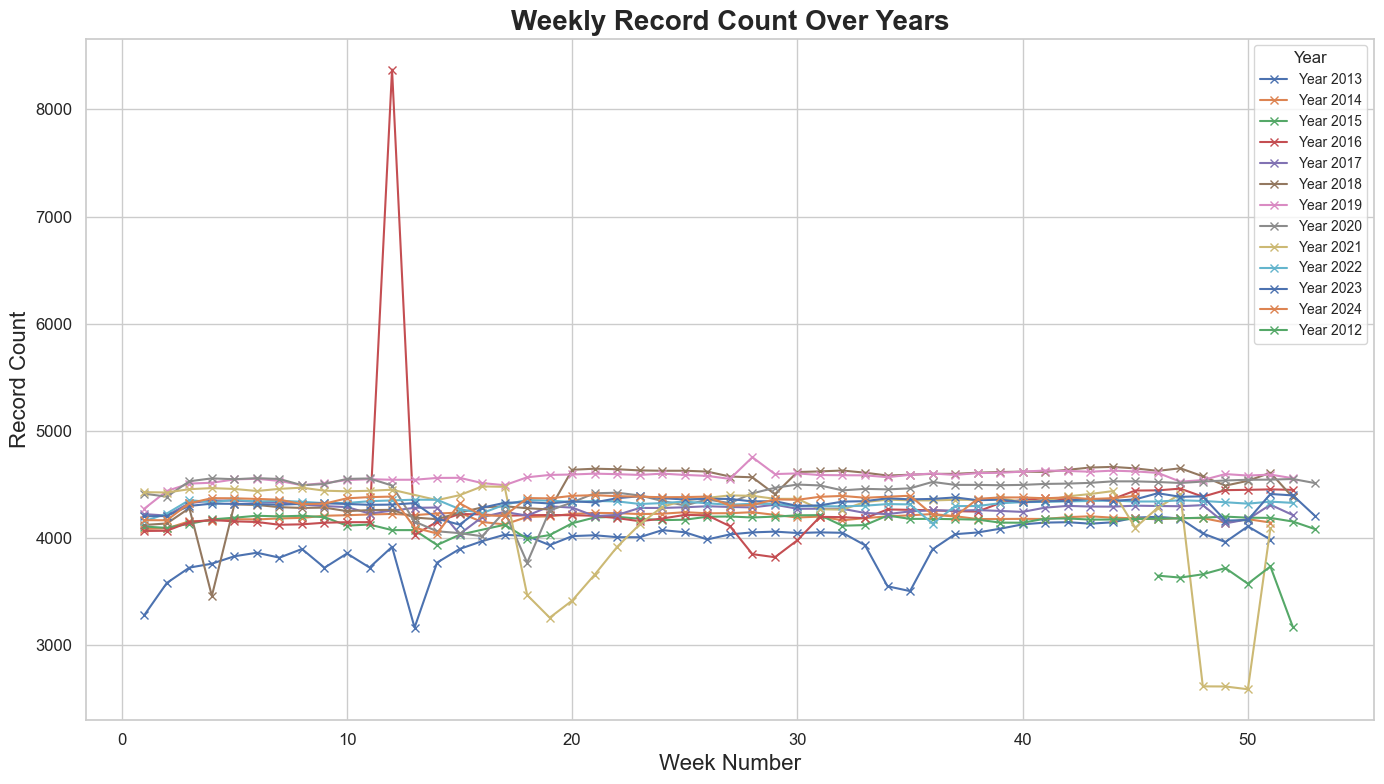

In [66]:

plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Plotting one line per year
for year in df['anho'].unique():
    year_data = df[df['anho'] == year]
    plt.plot(year_data['semana_no'], 
             year_data['record_count'], 
             marker='x', 
             label=f'Year {year}')

# mugre
plt.title('Weekly Record Count Over Years', fontsize=20, weight='bold')
plt.xlabel('Week Number', fontsize=16)
plt.ylabel('Record Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Year', loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [98]:
query = """
WITH latest_two_weeks AS (
    SELECT 
        pp.ciudad AS city, 
        pn.english_product AS product, 
        pp.semana_no AS week, 
        pp.anho AS year, 
        AVG(pp.precio_medio) AS avg_price, 
        date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) AS date
    FROM product_prices pp
    LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
    WHERE date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) >= (
        SELECT MAX(date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1)) - interval '7 days' 
        FROM product_prices pp
    )
    AND pp.ciudad = 'medellin'
    GROUP BY pp.ciudad, pn.english_product, pp.semana_no, pp.anho
),
week_price_difference AS (
    SELECT 
        current.city,
        current.product,
        current.year,
        current.week,
        current.avg_price AS current_avg_price,
        previous.avg_price AS previous_avg_price,
        ((current.avg_price - previous.avg_price) / previous.avg_price) * 100 AS percentage_change
    FROM latest_two_weeks current
    LEFT JOIN latest_two_weeks previous 
        ON current.product = previous.product 
        AND current.city = previous.city
        AND (
            current.week = previous.week + 1 
            OR (current.week = 1 AND previous.week = 52 AND current.year = previous.year + 1)
        )
       
    WHERE previous.avg_price IS NOT NULL
)
-- Get top 20 most significant price increases and top 20 decreases
(
    SELECT *
    FROM week_price_difference
    WHERE percentage_change > 0
    ORDER BY percentage_change DESC
    LIMIT 20
)
UNION ALL
(
    SELECT *
    FROM week_price_difference
    WHERE percentage_change < 0
    ORDER BY percentage_change ASC
    LIMIT 20
)
ORDER BY percentage_change DESC;
"""
df = run.queries_on_rds(query = query) 
df['product'] = df['product'].str.replace('_',' ').str.title()

C:\Users\Windows\AppData\Local\Temp\ipykernel_7044\3816526107.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Windows\AppData\Local\Temp\ipykernel_7044\3816526107.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


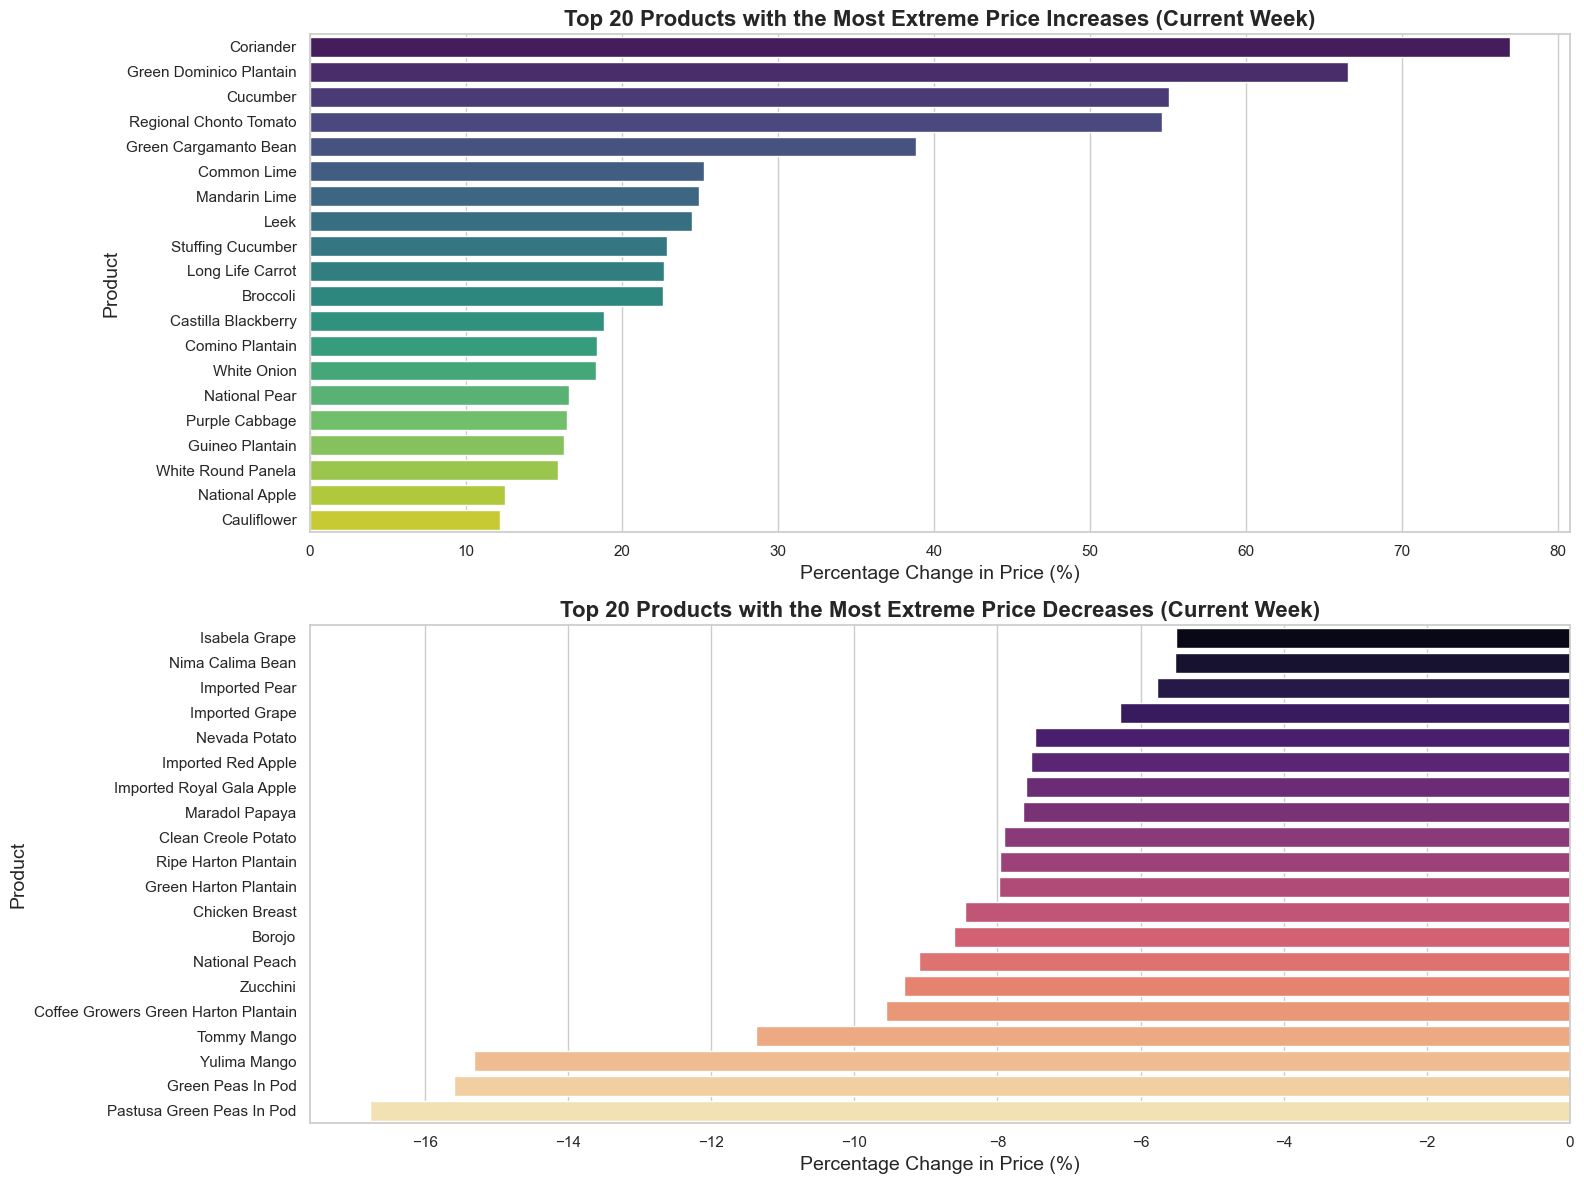

In [99]:
# Split the DataFrame into increasing and decreasing products
increases_df = df[df['percentage_change'] > 0]
decreases_df = df[df['percentage_change'] < 0]

# Set up the figure size and style
plt.figure(figsize=(16, 12))
sns.set(style="whitegrid")

# Create a subplot for increased prices
plt.subplot(2, 1, 1)
sns.barplot(
    data=increases_df,
    x='percentage_change',
    y='product',
    dodge=False,
    palette='viridis'
)
plt.title('Top 20 Products with the Most Extreme Price Increases (Current Week)', 
          fontsize=16, 
          weight='bold')
plt.xlabel('Percentage Change in Price (%)', fontsize=14)
plt.ylabel('Product', fontsize=14)

# Create a subplot for decreased prices
plt.subplot(2, 1, 2)
sns.barplot(
    data=decreases_df,
    x='percentage_change',
    y='product',
    dodge=False,
    palette='magma'
)
plt.title('Top 20 Products with the Most Extreme Price Decreases (Current Week)', 
          fontsize=16, 
          weight='bold')
plt.xlabel('Percentage Change in Price (%)', fontsize=14)
plt.ylabel('Product', fontsize=14)

# Adjust layout for readability
plt.tight_layout()

# Display the plot
plt.show()

In [66]:
query = """
    SELECT mercado, count(*) as mercado_count FROM product_prices 
    GROUP BY mercado
    ORDER BY mercado_count DESC;
"""

In [67]:
df = run.queries_on_rds(query = query)

In [68]:
df['mercado'] = df['mercado'].str.replace('_',' ')

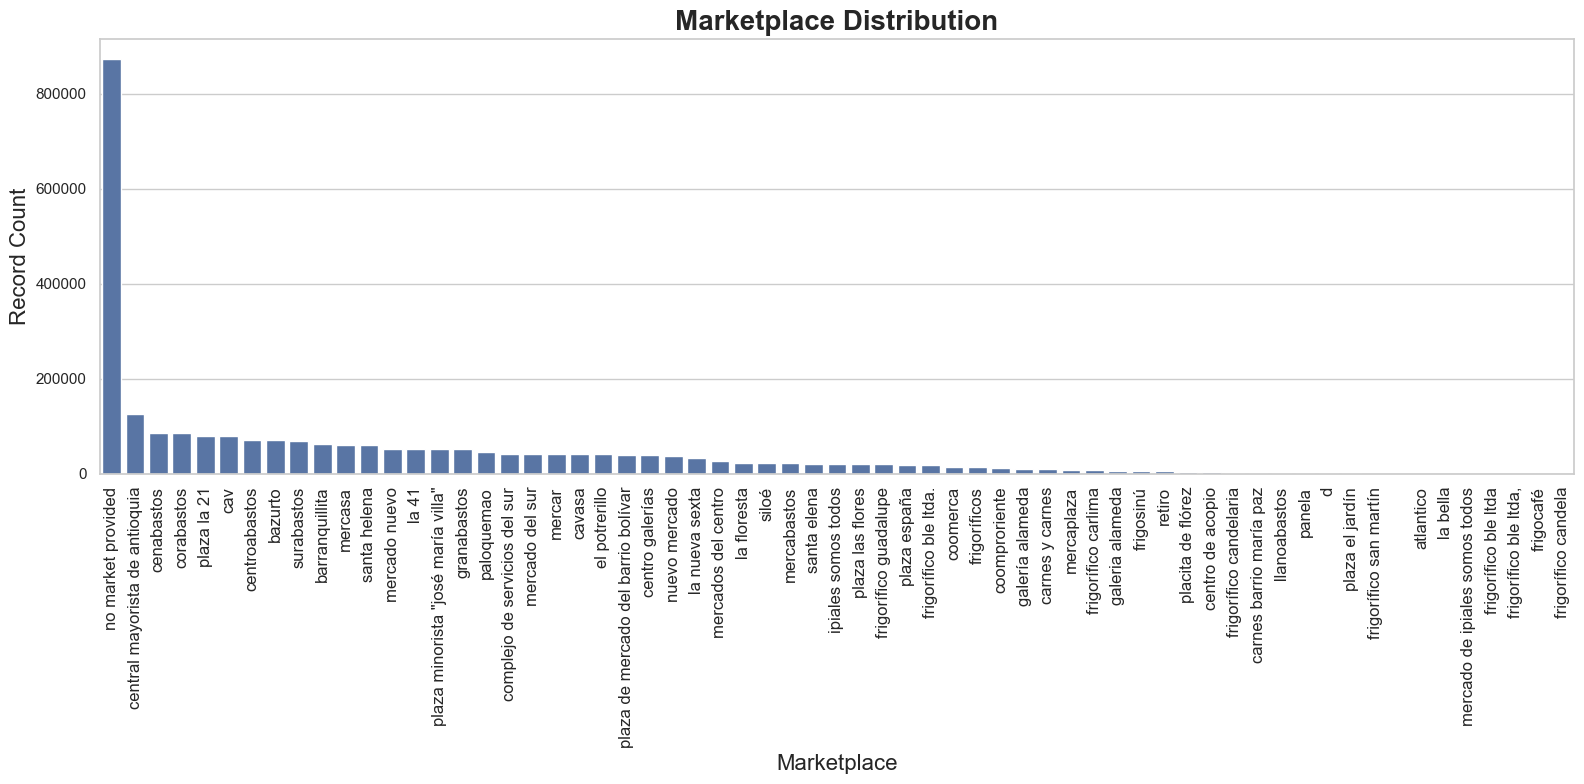

In [69]:
plt.figure(figsize = (16,8))
sns.set(style = 'whitegrid')
sns.barplot(df, x = 'mercado', y = 'mercado_count')
plt.title('Marketplace Distribution', fontsize=20, weight='bold')

plt.ylabel('Record Count', fontsize=16)
plt.xlabel('Marketplace', fontsize = 16)
plt.xticks(fontsize = 12, rotation = 90)
plt.tight_layout()
plt.show()

### Price Trends Across Time

#### How do prices of different product categories evolve over time?

Hypotheses for Exploratory Data Analysis

- Hypothesis 1: Prices of Perishable Goods Exhibit Greater Fluctuations.

idea: Compare the variance in prices between fresh products like fruits and vegetables vs. processed products or canned goods. standard deviation or coefficient of variation to quantify this?

- Hypothesis 2: Prices Tend to Increase Over Time Due to Inflationary Pressure.

idea: Analyze the time series data to see if prices show a general upward trend across product categories. linear regression to estimate the rate of increase?

- Hypothesis 3: Certain Cities Exhibit Higher Prices Due to Transportation and Supply Chain Costs.

idea: Compare the average prices for each product across different cities, controlling for product categories. ANOVA to check if certain cities consistently have higher or lower prices?
- Hypothesis 4: Seasonality Has a Strong Effect on the Price of Fresh Produce.

idea: Investigate the prices of seasonal fruits and vegetables across different weeks of the year to see if there are consistent price spikes during specific seasons (e.g., holidays, harvest times).

- Hypothesis 5: Price Movements in Major Marketplaces are Leading Indicators for Other Regions.

idea: Check if price changes in major markets (e.g., Bogotá, Medellín) are followed by similar changes in smaller or more remote marketplaces. price correlations? with a time lag?

- Hypothesis 6: Imported Products Show Less Price Fluctuation Compared to Locally Produced Goods.

idea: Compare the price volatility of imported vs. locally produced goods, particularly in categories like fish and processed goods.

- Hypothesis 7: The "Trend" Column Is a Good Predictor of Future Price Changes.

idea: Analyze whether the "+" and "-" trend indicators actually correspond to the direction of price movement in subsequent weeks.trend prediction over time?.

- Hypothesis 8: Prices of High-Demand Products Will Have a Lower Rate of Increase Compared to Low-Demand Products.

idea: get demand data to cross-referenced market behaviour. Correlation? 

In [16]:
import statsmodels.api as sm

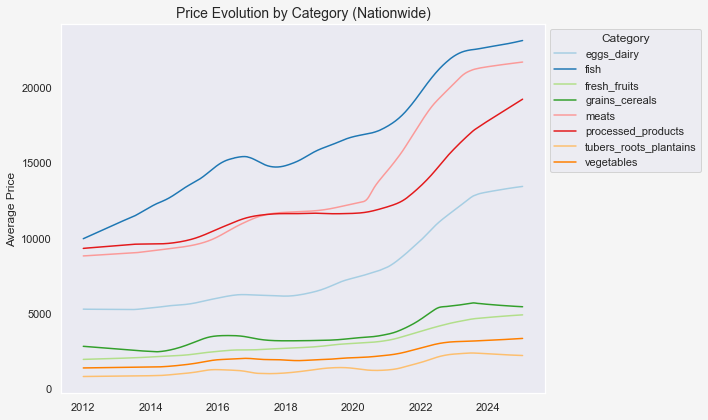

In [17]:
query = """
SELECT 
    AVG(precio_medio) as mean_price,
    english_category as category,
    date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) as date
FROM product_prices pp
LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
-- WHERE ciudad = 'bogota'
GROUP BY english_category, date
ORDER BY date;
"""
dataframe = run.queries_on_rds(query = query)
# df.sample(10)

def lineplot_per_category(dataframe: pd.DataFrame,
                          numerical_value: str, 
                          categorical_value: str,
                          date_column: str = 'date',
                          frac: float = 0.2,
                          xlabel: str = 'Date',
                          ylabel: str = 'Smoothed Value',
                          title: str = None) -> None:
    """
    Creates a line plot with LOWESS smoothing for each category in the dataset.
    
    Args:
        dataframe (pd.DataFrame): The data to plot.
        numerical_value (str): The name of the numerical column to plot.
        categorical_value (str): The name of the categorical column for grouping.
        date_column (str): The name of the date column. Default is 'date'.
        frac (float): Smoothing parameter for LOWESS. Default is 0.2.
        xlabel (str): Label for the x-axis. Default is 'Date'.
        ylabel (str): Label for the y-axis. Default is 'Smoothed Value'.
        title (str): Custom title for the plot. Default is generated based on inputs.
    """
    
    # Check if necessary columns exist in the dataframe
    if not all(col in dataframe.columns for col in [numerical_value, categorical_value, date_column]):
        raise ValueError("One or more columns are missing in the provided dataframe.")
    
    # Set up the color palette based on the number of unique categories
    n_categories = dataframe[categorical_value].nunique()
    custom_palette = sns.color_palette("Paired", n_colors=n_categories)
    
    # Set up the figure size and style
    plt.figure(figsize=(10, 6))

    plt.gcf().set_facecolor('#f5f5f5')  # Set figure background color (light gray)
    sns.set(style="dark", palette=custom_palette)
    
    # Plot each category with LOWESS smoothing
    for i, category in enumerate(dataframe[categorical_value].unique()):
        subset = dataframe[dataframe[categorical_value] == category]
        smoothed_values = sm.nonparametric.lowess(subset[numerical_value], subset[date_column], frac=frac)
        plt.plot(subset[date_column], smoothed_values[:, 1], label=category, color=custom_palette[i])
    
    # Add plot title and labels
    if not title:
        title = f'Lowess Smoothed Average {numerical_value} by {categorical_value} Over Time'
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Set axis background color
    plt.gca().set_facecolor('#eaeaf2')
    
    # Customize legend
    plt.legend(title=categorical_value.capitalize(), loc='upper left', bbox_to_anchor=(1, 1))
    
    # Display the plot with tight layout
    plt.tight_layout()
    plt.show()

lineplot_per_category(dataframe = dataframe, 
                      numerical_value = 'mean_price' ,
                      categorical_value = 'category', 
                      title = 'Price Evolution by Category (Nationwide)',                   
                      xlabel = '', 
                      ylabel = 'Average Price')

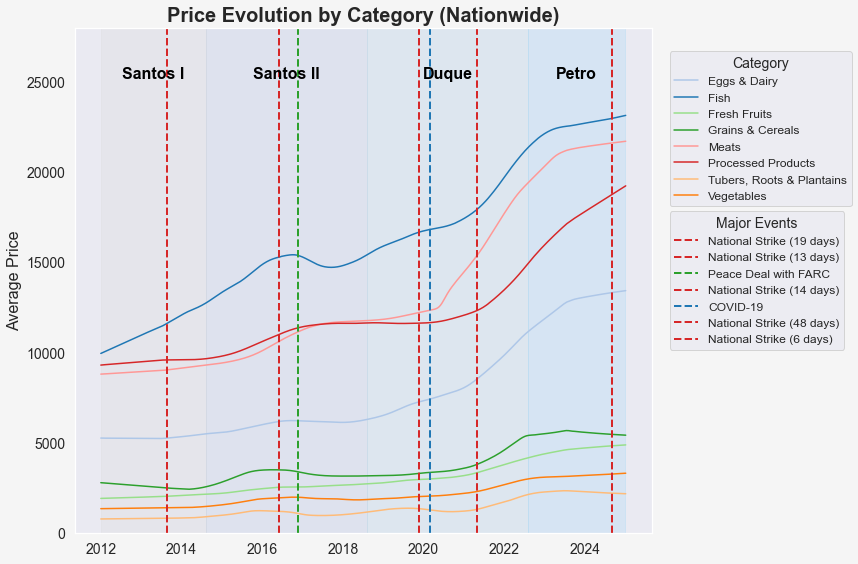

In [35]:
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from io import BytesIO

def lineplot_per_category_nationwide(dataframe: pd.DataFrame,
                                     numerical_value: str, 
                                     categorical_value: str,
                                     date_column: str = 'date',
                                     frac: float = 0.2,
                                     xlabel: str = 'Date',
                                     ylabel: str = 'Average Price',
                                     title: str = None) -> None:
    """
    Creates a line plot with LOWESS smoothing for each category in the dataset,
    includes shaded areas indicating different presidencies, and adds separate boxes for major events and category legends.
    
    Args:
        dataframe (pd.DataFrame): The data to plot.
        numerical_value (str): The name of the numerical column to plot.
        categorical_value (str): The name of the categorical column for grouping.
        date_column (str): The name of the date column. Default is 'date'.
        frac (float): Smoothing parameter for LOWESS. Default is 0.2.
        xlabel (str): Label for the x-axis. Default is 'Date'.
        ylabel (str): Label for the y-axis. Default is 'Average Price'.
        title (str): Custom title for the plot. Default is generated based on inputs.
    """
    
    # Define a fixed order for categories and corresponding color palette
    category_order = [
        'eggs_dairy',
        'fish',
        'fresh_fruits',
        'grains_cereals',
        'meats',
        'processed_products',
        'tubers_roots_plantains',
        'vegetables'
    ]

    category_labels = {
        'eggs_dairy': 'Eggs & Dairy',
        'fish': 'Fish',
        'fresh_fruits': 'Fresh Fruits',
        'grains_cereals': 'Grains & Cereals',
        'meats': 'Meats',
        'processed_products': 'Processed Products',
        'tubers_roots_plantains': 'Tubers, Roots & Plantains',
        'vegetables': 'Vegetables'
    }

    # Fixed color palette matching the desired order
    fixed_palette = [
        '#AEC7E8',  # light blue for eggs_dairy
        '#1F77B4',  # blue for fish
        '#98DF8A',  # light green for fresh_fruits
        '#2CA02C',  # green for grains_cereals
        '#FF9896',  # light pink for meats
        '#D62728',  # red for processed_products
        '#FFBB78',  # light orange for tubers_roots_plantains
        '#FF7F0E'   # orange for vegetables
    ]

    # Check if necessary columns exist in the dataframe
    if not all(col in dataframe.columns for col in [numerical_value, categorical_value, date_column]):
        raise ValueError("One or more columns are missing in the provided dataframe.")
    
    # Replace category values in the DataFrame
    dataframe[categorical_value] = dataframe[categorical_value].replace(category_labels)
    
    # Set up the figure size and style
    fig, ax = plt.subplots(figsize=(10, 8))

    fig.set_facecolor('#f5f5f5')  # Set figure background color (light gray)
    sns.set(style="dark")
    
    # Plot each category in the defined order with LOWESS smoothing
    for i, category in enumerate(category_order):
        if category_labels[category] in dataframe[categorical_value].values:
            subset = dataframe[dataframe[categorical_value] == category_labels[category]]
            smoothed_values = sm.nonparametric.lowess(subset[numerical_value], subset[date_column], frac=frac)
            ax.plot(subset[date_column], smoothed_values[:, 1], label=category_labels[category], color=fixed_palette[i])
    
    # Add plot title and labels with larger font size
    if not title:
        title = f'Price Evolution by Category (Nationwide)'
    ax.set_title(title, fontsize=20, weight='bold')  # Larger title
    ax.set_xlabel(xlabel, fontsize=16)  # Larger x-axis label
    ax.set_ylabel(ylabel, fontsize=16)  # Larger y-axis label
    
    # Set axis background color
    ax.set_facecolor('#eaeaf2')
    
    # Set y-axis limit to ensure uniform comparison
    ax.set_ylim(0, 28000)
    
    # Increase the font size for the ticks
    ax.tick_params(axis='both', labelsize=14)

    # Adding shaded areas for presidential terms
    presidential_periods = [
        ('2012-01-01', '2014-08-07', '#d3d3d3', 'Santos I'),  # Light gray
        ('2014-08-07', '2018-08-07', '#b0c4de', 'Santos II'),  # Light steel blue
        ('2018-08-07', '2022-08-07', '#add8e6', 'Duque'),      # Light blue
        ('2022-08-07', '2024-12-31', '#87cefa', 'Petro')       # Sky blue
    ]

    for start, end, color, label in presidential_periods:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.2)
        # Place the president names in the shaded areas with larger text
        ax.text(
            pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start)) / 2,
            ax.get_ylim()[1] * 0.9,  # Place at 90% of the y-axis height
            label,
            ha='center', fontsize=16, color='black', weight='bold'
        )
    
    # Adding vertical lines for major events with different colors
    events = [
        ('2013-08-19', 'National Strike (19 days)', '#d62728'),  # Red for strikes
        ('2016-05-30', 'National Strike (13 days)', '#d62728'),  # Red for strikes
        ('2016-11-24', 'Peace Deal with FARC', '#2ca02c'),  # Green for Peace Deal
        ('2019-11-20', 'National Strike (14 days)', '#d62728'),  # Red for strikes
        ('2020-03-01', 'COVID-19', '#1f77b4'),         # Blue for COVID-19
        ('2021-04-28', 'National Strike (48 days)', '#d62728'),  # Red for strikes
        ('2024-09-01', 'National Strike (6 days)', '#d62728'),  # Red for the recent strike during Petro's term
    ]

    event_legend_labels = []
    for event_date, event_label, color in events:
        ax.axvline(pd.to_datetime(event_date), color=color, linestyle='--', linewidth=2)
        event_legend_labels.append((plt.Line2D([], [], color=color, linestyle='--', linewidth=2), event_label))

    # Adding both legends in the right pane without overlapping the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])  # Adjust plot size to fit legends

    category_legend = plt.legend(title="Category", handles=ax.get_legend_handles_labels()[0], loc='center left', bbox_to_anchor=(1.02, 0.8), fontsize=12, title_fontsize=14)
    ax.add_artist(category_legend)  # Add category legend to the figure

    plt.legend(*zip(*event_legend_labels), loc='center left', bbox_to_anchor=(1.02, 0.5), title="Major Events", fontsize=12, title_fontsize=14)

    # Display the plot with tight layout using Streamlit
    plt.tight_layout()
    st.pyplot(fig)

    # Save the plot to a BytesIO buffer
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)

    # Provide a download button for the plot
    st.download_button(
        label="Download Plot as PNG",
        data=buf,
        file_name=f"lineplot_per_category.png",
        mime="image/png"
    )

# Assuming `dataframe` is obtained from the query
lineplot_per_category(dataframe=dataframe, 
                      numerical_value='mean_price',
                      categorical_value='category',
                      title='Price Evolution by Category (Nationwide)',
                      xlabel='',
                      ylabel='Average Price')


1. Overall Rising Trend: 

- Across all categories, there's a clear upward trend in prices, particularly noticeable from 2018 onwards. This indicates that inflation and increased costs of goods have impacted all food categories consistently.

2. Steep Increase for Fish and Meats:

- The categories fish (blue) and meats (red) have experienced the most significant price hikes, especially from 2020 to 2024.
- This may reflect supply chain disruptions, increased production costs, or rising demand for these products, possibly exacerbated by global or local events such as the COVID-19 pandemic or national strikes. 

3. Eggs, Dairy and Processed Products:

- eggs_dairy (light blue) and processed_products (light red) have also seen sharp price increases, though less dramatic than fish and meats.
- Eggs and Diary prices have seen gradual but steady increases, which could reflect changes in dynamics, sustainability concerns, or rising demand for seafood.

4. Grains, Vegetables, and Tubers:

- Categories like grains_cereals (green), vegetables (orange), and tubers_roots_plantains (yellow) have experienced a more stable price evolution. While prices have risen, the increases have been more moderate, with less dramatic fluctuations.
- These products might be more locally sourced or have more stable supply chains, leading to less volatility compared to animal products.

5. Potential Influences:

- The noticeable increases around 2020–2022 could be tied to global supply chain issues due to the pandemic, which likely drove up transportation and production costs.
- National economic events, like strikes or governmental changes in agricultural policies, could also explain certain price peaks, especially in highly impacted sectors like meat and dairy.
- The impact of international trade, such as tariffs or import restrictions, might also be reflected in the sharp rise of fish and processed products.

<!-- ##### Bogota -->

#### Are there significant seasonal patterns in product prices?

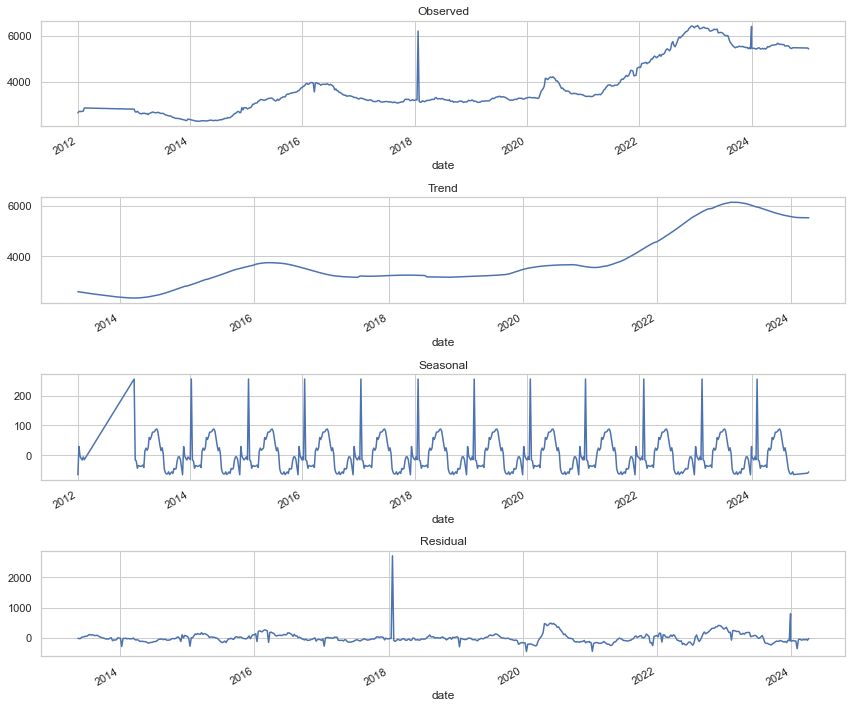

In [21]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

query = """
SELECT 
    date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) as date,
    AVG(precio_medio) as mean_price
FROM product_prices pp
LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
WHERE english_category = 'grains_cereals'  -- grains_cereals SELECTED! 
GROUP BY date
ORDER BY date;

"""
df = run.queries_on_rds(query = query)

# Assume df is the DataFrame from the SQL query, containing 'date' and 'mean_price'
ts = df.set_index('date')['mean_price']  # Set date as the index for the time series

# Perform seasonal decomposition with an additive model and period of 52 (weeks)
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=52)

# Plot the decomposition with a larger figure size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))  # Adjust figure size
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')

plt.tight_layout()
plt.show()


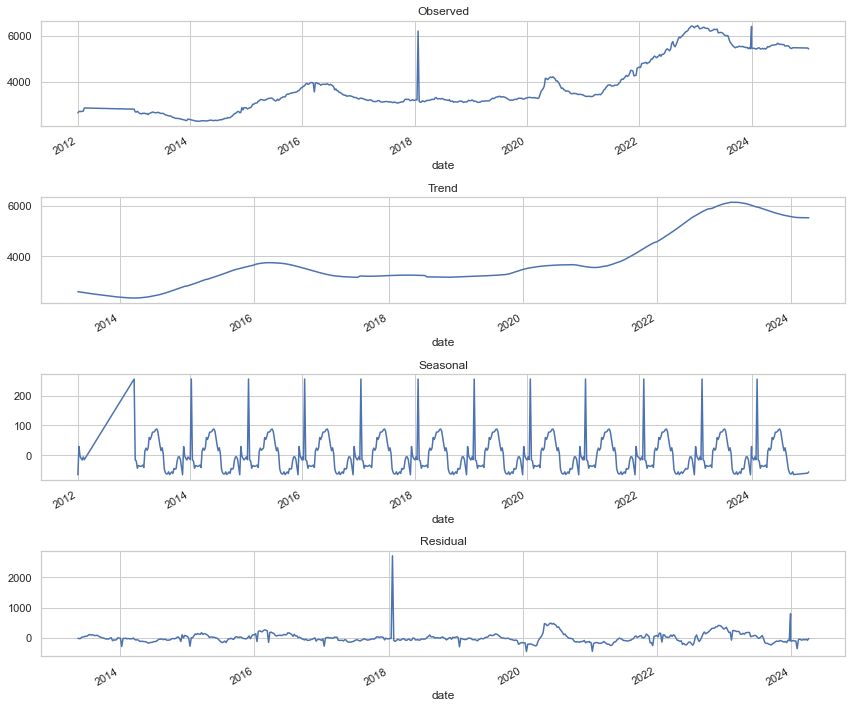

In [21]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

query = """
SELECT 
    date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) as date,
    AVG(precio_medio) as mean_price
FROM product_prices pp
LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
WHERE english_category = 'grains_cereals'  -- grains_cereals SELECTED! 
GROUP BY date
ORDER BY date;

"""
df = run.queries_on_rds(query = query)

# Assume df is the DataFrame from the SQL query, containing 'date' and 'mean_price'
ts = df.set_index('date')['mean_price']  # Set date as the index for the time series

# Perform seasonal decomposition with an additive model and period of 52 (weeks)
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=52)

# Plot the decomposition with a larger figure size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))  # Adjust figure size
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')

plt.tight_layout()
plt.show()


1. Observed (Top Panel):

- The overall price pattern shows a steady rise over time, with some fluctuations.
- There is a notable spike around 2018, likely indicating a significant event that impacted prices sharply.
- After 2020, prices gradually rise again and reach a peak, which starts to flatten post-2022.

2. Trend (Second Panel):
- The trend component shows the long-term price movement without seasonal or irregular variations.
- From 2012 to 2017, prices remained relatively flat, indicating a stable market trend.
- From 2018 onwards, there is a gradual upward trend, peaking between 2022 and 2023, after which it starts to decline slightly.

3. Seasonal (Third Panel):
- The seasonal component highlights recurring patterns, with noticeable price peaks at regular intervals every year, especially near the beginning of each year (weeks 50-1).
- This indicates significant seasonal effects, likely influenced by agricultural cycles, holidays, or other regular events that drive prices up annually.
- These seasonal fluctuations remain relatively consistent over time.

4. Residual (Bottom Panel):
- The residuals show the random variations after removing the trend and seasonal components.
- There are some significant residuals around 2018, suggesting the presence of an outlier or a shock event (possibly related to political unrest, strikes, or global economic conditions).
- For most of the time series, residuals remain fairly stable, indicating that the model captures the main trends and seasonal patterns well.

Main Takeaways:
- There is a clear seasonal pattern in the data, with recurring price peaks at specific times of the year.
- The trend indicates a notable price increase from 2018 onwards, followed by a slight flattening post-2022.
- A large price spike occurred in 2018, which could be attributed to an external event, such as a political or economic disruption.
- The model effectively decomposes the observed prices into their components, helping to understand both long-term trends and short-term fluctuations.

These findings suggest that prices are strongly influenced by seasonality, and there may be external shocks (such as strikes or global market conditions) affecting long-term trends.

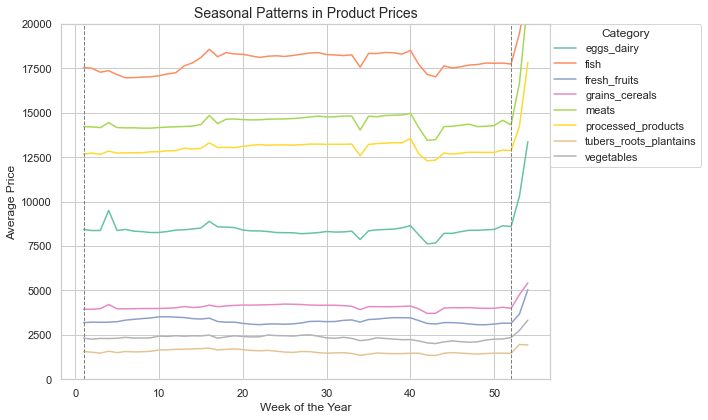

In [20]:
query = """
SELECT 
    english_category AS category,
    semana_no AS week_of_year, -- Week of the year (1-52)
    EXTRACT(MONTH FROM to_date(anho::text, 'YYYY') + interval '1 week' * (semana_no - 1)) AS month, -- Month for additional analysis
    AVG(precio_medio) AS avg_price, -- Average price for each week of the year
    COUNT(*) AS records_per_week -- Count of records per week (optional)
FROM product_prices pp
LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
WHERE anho >= 2015 -- Filter for a period of at least several years
GROUP BY category, semana_no, EXTRACT(MONTH FROM to_date(anho::text, 'YYYY') + interval '1 week' * (semana_no - 1))
ORDER BY category, semana_no;

"""
df = run.queries_on_rds(query = query)

# Assuming df_seasonal contains the result from the SQL query
plt.figure(figsize=(10, 6))

# Set a custom color palette
sns.set(style="whitegrid")
custom_palette = sns.color_palette("Set2")

# Lineplot with LOWESS smoothing and specific category colors
sns.lineplot(data=df, x='week_of_year', y='avg_price', hue='category', palette=custom_palette)

# Add plot title and labels
plt.title('Seasonal Patterns in Product Prices', fontsize=14)
plt.xlabel('Week of the Year', fontsize=12)
plt.ylabel('Average Price', fontsize=12)

# Highlight specific weeks (e.g., Week 1, Week 52)
highlight_weeks = [1, 52]
for week in highlight_weeks:
    plt.axvline(x=week, color='gray', linestyle='--', lw=1)  # Vertical line for highlight

# Add annotations for important points
max_point = df[df['avg_price'] == df['avg_price'].max()]
plt.annotate('Highest Price', xy=(max_point['week_of_year'], max_point['avg_price']),
             xytext=(max_point['week_of_year'] + 2, max_point['avg_price'] + 2000),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=10)

# Adjust the y-axis limits to focus more on lower price ranges (optional)
plt.ylim(0, 20000)

# Improve the legend placement and appearance
plt.legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)

# Display the refined plot
plt.tight_layout()
plt.show()


1. Stable Trends for Most Categories

For many categories (like the ones shown in lower price ranges), there is stability in prices over the year. There are small fluctuations, but nothing drastic across weeks.

2. Slight Price Spikes for Some Categories

There are subtle spikes for some categories during certain weeks, which could correspond to seasonal events or supply chain 

3. fluctuations

Around weeks 15-20 (around April-May), there seems to be a slight increase for several categories. This could correspond to Easter or local holidays, which often lead to changes in demand and supply.
Similarly, a modest spike is seen around week 50 (November-December), potentially linked to the holiday season where demand tends to rise.

4. Category-wise Price Differences. The price differences between categories are apparent

Some categories, like the top two lines, possibly representing meat or dairy products, have much higher prices compared to categories like vegetables or grains.
This confirms that some categories (especially perishable or imported products) experience higher costs throughout the year, and potentially higher volatility.

5. Limited Seasonal Volatility

While there are noticeable seasonal patterns, especially during the early and late parts of the year, the prices don't show dramatic swings. This may indicate relatively stable supply chains for the categories presented.

#### How do weekly price fluctuations compare across different product categories?

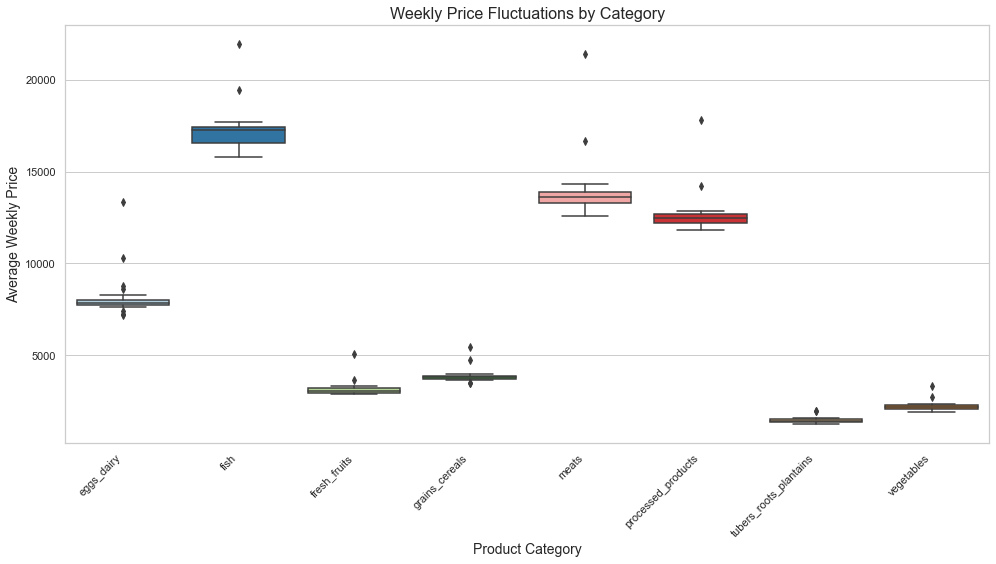

In [25]:
query = """
SELECT 
    english_category AS category,
    semana_no AS week_of_year,
    AVG(precio_medio) AS avg_price
FROM product_prices pp
LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
GROUP BY english_category, semana_no
ORDER BY english_category, semana_no;


"""
dataframe = run.queries_on_rds(query = query)


# Set plot style for better visualization
sns.set(style="whitegrid")

# Create a boxplot to visualize weekly fluctuations across categories
plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x='category', 
    y='avg_price', 
    data=dataframe, 
    palette='Paired'
)

# Set plot labels and title for context
ax.set_title('Weekly Price Fluctuations by Category', fontsize=16)
ax.set_xlabel('Product Category', fontsize=14)
ax.set_ylabel('Average Weekly Price', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

# Display the plot
plt.tight_layout()
plt.show()


1. Category Variability:

Fish:
- The fish category stands out as having the highest variability in average weekly prices.
- The wide range of the box and long whiskers indicate substantial price fluctuations week-to-week.
- The presence of multiple outliers above the box suggests that there are weeks when prices were significantly higher.

Meats and Processed Products:
- Both meats and processed_products show moderate variability.
- The boxes for these categories are relatively larger than others, indicating some price fluctuations but still not as extreme as fish.
- They also have a few outliers, which shows occasional high spikes in price.

Eggs_Dairy:
- eggs_dairy has a slightly more concentrated spread compared to fish, but still shows some degree of weekly variability.

Tubers_Roots_Plantains and Vegetables:
- Categories like tubers_roots_plantains and vegetables have smaller boxes and shorter whiskers.
- This indicates that these categories have relatively stable prices and do not fluctuate as much on a weekly basis.
- It also suggests that these items are more stable and predictable in pricing.

Fresh Fruits and Grains_Cereals:
- Similar to vegetables, these categories show lower weekly price variability, with tightly concentrated boxes and fewer outliers.

2. Central Tendency:

The median (the line inside each box) is noticeably higher for fish and meats compared to other categories.
This indicates that on average, these products tend to have higher weekly prices compared to other product categories.

3. Outliers:

Many categories have outliers, which indicate weeks with unusually high prices. For instance, fish, meats, and eggs_dairy show sporadic high prices.
Outliers could be caused by supply chain issues, seasonality, or external market pressures affecting specific weeks.

### City and Regional Comparisons

#### How do the average prices of the same products vary across different cities in Colombia?

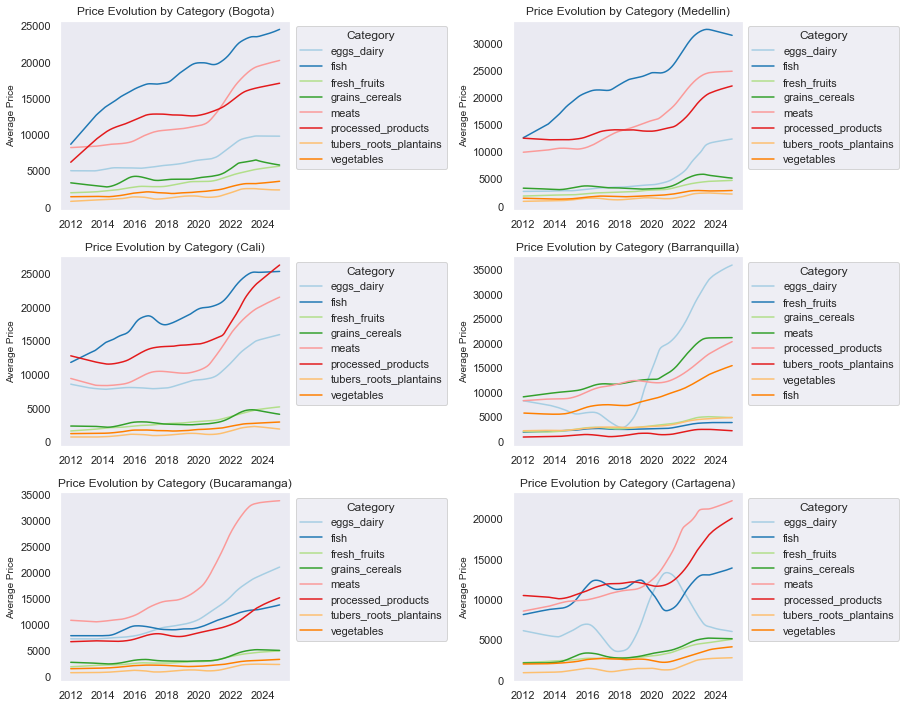

In [10]:

# Create a grid of subplots with n_rows and n_cols
n_rows = 3
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flatten axes for easier iteration
axes = axes.flatten()

# Initialize a dictionary to map categories to colors
categories = set()

for i, city in enumerate(('bogota', 'medellin', 'cali','barranquilla','bucaramanga','cartagena')):
    query = f"""
    SELECT 
        AVG(precio_medio) as mean_price,
        english_category as category,
        date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) as date
    FROM product_prices pp
    LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
    LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
    WHERE ciudad = '{city.lower()}'
    GROUP BY english_category, date
    ORDER BY date;
    """
    dataframe = run.queries_on_rds(query=query)

    # Collect categories for the combined legend
    categories.update(dataframe['category'].unique())

    # Plot each subplot without a legend
    lineplot_per_category_grid(dataframe=dataframe, 
                               numerical_value='mean_price',
                               categorical_value='category', 
                               ax=axes[i],  # Pass each axis to the function
                               title=f'Price Evolution by Category ({city.capitalize()})', 
                               xlabel='', 
                               ylabel='Average Price',
                               show_legend=True)  # Disable legend in individual plots

# Create a fixed color palette for all categories
custom_palette = sns.color_palette("Paired", n_colors=len(categories))

# Add the legend outside the grid
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
plt.show()

1. Consistency in National Price Trends:

Across all cities, there are consistent trends, especially in categories like eggs_dairy (blue), meats (red), and fish (light blue). These categories consistently show sharp price increases, especially from 2020 onward.
The rising prices of meats and eggs_dairy are common across the cities, though the degree of increase varies slightly between locations.

2. Regional Price Differences:

Barranquilla and Bucaramanga show steeper increases in food prices overall, particularly in categories like eggs_dairy and meats. This could reflect regional supply issues, greater demand, or transportation costs driving prices up.
Cali, Cartagena, and Bogota show less extreme price increases, but they still follow the same upward trend, especially for meats and processed_products.

3. More Stability in Vegetables and Tubers:

Across all cities, vegetables (orange) and tubers_roots_plantains (yellow) have shown relatively stable prices. The prices for these categories remain much lower than for animal-based products.
This could indicate that vegetable and tuber prices are more resilient to economic pressures or that they are locally sourced, which reduces transportation and import costs.

4. Fish Prices:

Fish prices show marked variability across cities. In Barranquilla and Cali, fish prices are more volatile and tend to rise significantly, whereas in cities like Bogota, the increase is more gradual.
Being a coastal city, Barranquilla's steep rise in fish prices could reflect disruptions in the supply chain or increased demand for seafood.

#### Are there regional trends where certain products are consistently cheaper or more expensive in specific cities or marketplaces?


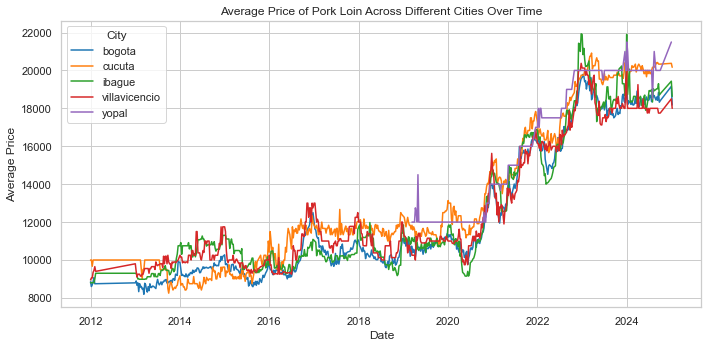

In [57]:
query = """
SELECT 
    pn.english_product AS product,
    pp.ciudad AS city,
    AVG(pp.precio_medio) AS avg_price,
    pp.anho AS year,
    pp.semana_no AS week,
    date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) as date
FROM product_prices pp
LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
WHERE pn.english_product = 'pork_loin'  -- Adjust as needed
GROUP BY pn.english_product, pp.ciudad, pp.anho, pp.semana_no
ORDER BY pn.english_product, pp.ciudad, pp.anho, pp.semana_no;


"""
df = run.queries_on_rds(query = query)

# Assuming 'df' contains the results of the SQL query
# df['date'] = pd.to_datetime(df['year'].astype(str) + '-W' + df['week'].astype(str) + '-1', format='%Y-W%W-%w')

# Plotting price evolution across different cities
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='date', y='avg_price', hue='city', palette='tab10')

plt.title('Average Price of Pork Loin Across Different Cities Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(title='City')
plt.tight_layout()
plt.show()

1. Price Trends Across Cities

- Overall, it seems that the average price of pork loin follows a similar upward trend across all the cities.
- The upward trend is particularly evident from 2018 onwards, with a marked increase in prices around 2020 to 2022, which could be linked to the pandemic's impact on supply chains.

2. Price Level Comparisons

There are some differences in the price levels across the cities:
- Bogotá (blue line): Appears to have consistently lower prices in comparison to other cities, particularly before 2020. This may indicate more competitive pricing in a larger urban market with more options for consumers and better supply chain efficiency.
- Villavicencio (orange line) and Cúcuta (red line): Often show higher peaks compared to Bogotá. These peaks indicate that these cities might experience supply disruptions or higher transportation costs, leading to short-term price surges.
3. Price Volatility:

Volatility (how much the prices fluctuate) differs between cities:
- Villavicencio shows larger price spikes around 2020, potentially due to logistical challenges or regional supply chain issues.
- The variability in Yopal (purple line) seems greater after 2022, suggesting potential instability in either demand or supply for that city.
- Bogotá shows a relatively more stable trend, implying better infrastructure or a broader supply network that is less susceptible to regional disruptions.

4. Event-Driven Changes:

- Around 2020, all cities experienced a sharp increase in prices, which corresponds with the onset of the COVID-19 pandemic. During this time, logistical restrictions and increased demand may have impacted pork supply, causing prices to surge.
- Similarly, there are distinct surges in prices during 2021 and 2022, which might indicate effects from national strikes or other socio-political events impacting supply chains.

#### Do particular regions show higher price volatility for certain categories, like fresh fruits or meats?

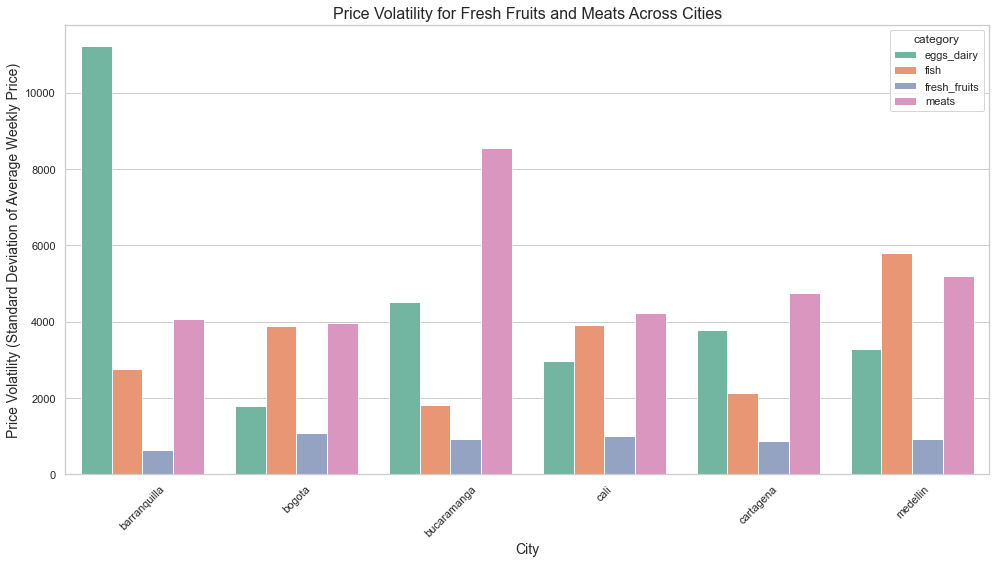

In [59]:

query = """
SELECT 
    cn.english_category AS category,
    pp.ciudad AS city,
    pp.anho AS year,
    pp.semana_no AS week,
    AVG(pp.precio_medio) AS avg_price
FROM product_prices pp
LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
WHERE cn.english_category IN ('fresh_fruits', 'meats','eggs_dairy', 'fish')
AND pp.ciudad in ('bogota', 'medellin', 'cali','barranquilla', 'bucaramanga', 'cartagena')
GROUP BY cn.english_category, pp.ciudad, pp.anho, pp.semana_no
ORDER BY cn.english_category, pp.ciudad, year, week;

"""


df = run.queries_on_rds(query = query)

# Calculate the standard deviation for each city and category to measure volatility
volatility_df = df.groupby(['category', 'city'])['avg_price'].std().reset_index()
volatility_df.rename(columns={'avg_price': 'price_volatility'}, inplace=True)

# Plot the volatility for each city and category using a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=volatility_df, x='city', y='price_volatility', hue='category', palette='Set2')

# Set plot title and labels
plt.title('Price Volatility for Fresh Fruits and Meats Across Cities', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Price Volatility (Standard Deviation of Average Weekly Price)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Extreme Volatility in Eggs & Dairy:

- Barranquilla stands out, with eggs_dairy showing an extraordinarily high standard deviation of over 10,000. This indicates significant fluctuations in the price of eggs and dairy in Barranquilla over time.
- This kind of volatility may suggest underlying factors such as irregular supply, high sensitivity to external disruptions, or inconsistent local production.
2. Meats Price Volatility Remains Consistently High:

Meats have the highest volatility in most of the cities:
- Bucaramanga, Medellín, and Cali show significantly high volatility for meats, suggesting that meat products are prone to price fluctuations in these regions.
- This could point to vulnerabilities in meat supply chains, susceptibility to external factors like feed price variability, or transportation challenges.
- Meat price volatility is noticeably lower in Barranquilla compared to other cities, while Medellín and Bucaramanga show consistently high variations.

3. Price Volatility for Fresh Fruits:

- Fresh fruits have moderate price volatility compared to other categories but are consistently less volatile than meats.
- Cali and Bogotá have similar volatility patterns for fresh fruits, with the values ranging between 1,500 to 2,500 in standard deviation. This suggests a relatively stable pricing environment, potentially due to local production and availability.

4. Fish Prices are Moderately Stable:

- Fish has a moderate level of price volatility across all cities, with Medellín showing slightly higher levels of fluctuation.
- Bogotá, Bucaramanga, and Cartagena have notably lower fish price volatility, indicating better stability.
5. Variation in Price Volatility for Eggs & Dairy:

- The very high volatility for eggs_dairy in Barranquilla is significantly greater compared to other cities. In Cali and Medellín, the prices of eggs and dairy show relatively less fluctuation.
- This stark difference might be due to production capacity, consumption behavior, or logistical challenges specific to Barranquilla.

### Category-Specific Trends

#### Do processed products exhibit more stable price patterns compared to fresh products like vegetables or fish?


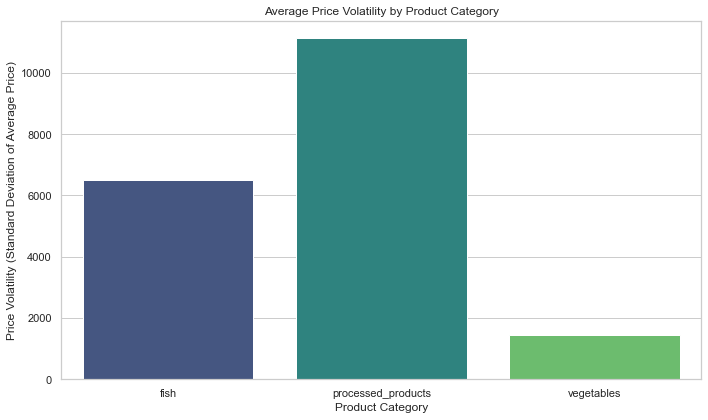

In [60]:
query = """
SELECT 
    cn.english_category AS category,
    pp.ciudad AS city,
    AVG(pp.precio_medio) AS avg_price,
    STDDEV(pp.precio_medio) AS price_stddev,   -- Calculate standard deviation for price volatility
    COUNT(*) AS count_data_points,
    pp.anho AS year,
    pp.semana_no AS week,
    date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) AS date
FROM 
    product_prices pp
LEFT JOIN 
    category_names cn ON pp.categoria = cn.spanish_category
WHERE 
    cn.english_category IN ('processed_products', 'vegetables', 'fish')  -- Limit to specific categories
GROUP BY 
    cn.english_category, pp.ciudad, pp.anho, pp.semana_no
ORDER BY 
    cn.english_category, pp.ciudad, pp.anho, pp.semana_no;

"""


df_volatility = run.queries_on_rds(query = query)

# Calculate volatility for each category as standard deviation
df_volatility_summary = df_volatility.groupby('category').agg({
    'avg_price': 'mean',
    'price_stddev': 'mean'
}).reset_index()

# Plotting Volatility
plt.figure(figsize=(10, 6))
sns.barplot(data=df_volatility_summary, x='category', y='price_stddev', palette='viridis')

plt.title('Average Price Volatility by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Price Volatility (Standard Deviation of Average Price)')
plt.tight_layout()
plt.show()

1. Processed Products typically tend to have more stable prices due to the nature of their long shelf life, bulk manufacturing, and standard pricing mechanisms. However, the result here shows that processed products are more volatile, which could imply:

- There may be underlying factors affecting their supply chain, such as cost of raw materials, production challenges, or demand fluctuations.
- It could also reflect significant price variations in different types of processed products included in the data, meaning that the category itself is diverse.
2. Fresh Products vs. Processed:

- Generally, you would expect processed products to have lower volatility due to better predictability of supply, but in this case, their prices have fluctuated more than fresh products like vegetables.
- The relatively lower volatility in vegetables suggests either that supply chains are well-established or that the timeframe considered did not involve major disruptions.

#### Which product categories are more susceptible to price changes or sudden spikes (e.g., due to seasonality, weather, supply chain issues)?


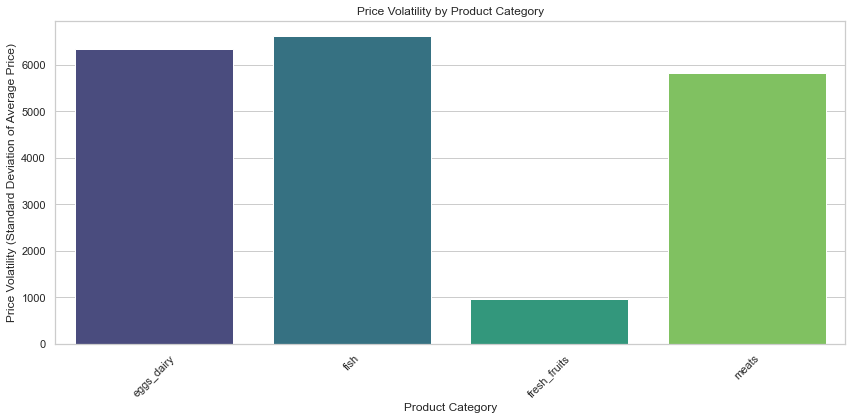

In [62]:
query = """
SELECT 
    pn.english_product AS product,
    cn.english_category AS category,
    pp.anho AS year,
    pp.semana_no AS week,
    AVG(pp.precio_medio) AS avg_price,
    date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) as date
FROM 
    product_prices pp
LEFT JOIN 
    product_names pn ON pp.producto = pn.spanish_product
LEFT JOIN 
    category_names cn ON pp.categoria = cn.spanish_category
GROUP BY 
    pn.english_product, cn.english_category, pp.anho, pp.semana_no
ORDER BY 
    pn.english_product, cn.english_category, pp.anho, pp.semana_no;


"""


category_volatility = run.queries_on_rds(query = query)

category_volatility = df.groupby('category')['avg_price'].std().reset_index()
category_volatility.columns = ['category', 'price_volatility']

# Plot the standard deviation to see which categories have the most volatile prices
plt.figure(figsize=(12, 6))
sns.barplot(data=category_volatility, x='category', y='price_volatility', palette='viridis')
plt.xticks(rotation=45)
plt.title('Price Volatility by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Price Volatility (Standard Deviation of Average Price)')
plt.tight_layout()
plt.show()

Volatility Ranking:

1. Fish and eggs/dairy categories exhibit the highest price volatility, with very similar levels.
2. Meats also show significant volatility, but less than fish and eggs/dairy.
3. Fresh fruits exhibit the lowest volatility among the four categories compared.

Implications:

1. High Volatility
- Categories like fish and eggs/dairy are likely more susceptible to external factors that cause frequent price fluctuations. This could be due to factors like seasonality, supply chain challenges, storage issues, or fluctuating consumer demand.
- Fish, in particular, might be affected by environmental factors like weather conditions, which impact fishing yields, or by logistics challenges that make the supply less predictable.
2. Medium to Low Volatility
- Meats also show considerable price movement, suggesting an influence from factors like feed costs, changes in agricultural policies, or even health concerns affecting supply.
- Fresh fruits have a relatively lower volatility, which may imply that the supply and pricing of fresh fruits have been relatively stable compared to other categories. This could be because they have shorter supply chains (often local) or because their availability is less impacted by major supply disruptions.

Conclusions:
- Fish and eggs/dairy categories are more susceptible to price changes and sudden spikes compared to fresh fruits. This suggests that their prices might be influenced more by market conditions, such as changing environmental factors, storage requirements, or volatile demand.
- Fresh fruits, with lower price variability, seem to maintain a more predictable price range. However, it would still be important to dig deeper into seasonal patterns to see if volatility changes at specific times of the year.
- Meats fall in between, indicating that while they do face some level of price volatility, it is still not as unstable as fish or eggs/dairy.

### Product Popularity and Trends

#### Which products are experiencing the most rapid price increases over time?

In [65]:
query = """
SELECT 
    pn.english_product AS product,
    AVG(pp.precio_medio) AS avg_price,
    pp.anho AS year,
    pp.semana_no AS week,
    date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) AS date
FROM product_prices pp
LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
WHERE pn.english_product = 'garlic'
GROUP BY pn.english_product, pp.anho, pp.semana_no
ORDER BY pn.english_product, pp.anho, pp.semana_no;

"""
df = run.queries_on_rds(query = query)
df
# # Ensure that date column is properly parsed as datetime
# df['date'] = pd.to_datetime(df['date'])

# # Sort values to ensure correct order
# df = df.sort_values(by=['product', 'date'])

# # Create a DataFrame to store the percentage price increase for each product
# percentage_changes = []

# # Loop through each product
# for product in df['product'].unique():
#     product_data = df[df['product'] == product]
    
#     # Ensure that product_data is not empty
#     if product_data.empty:
#         continue

#     # Calculate price change from the first to the last date in the dataset
#     initial_price = product_data['avg_price'].iloc[0]
#     final_price = product_data['avg_price'].iloc[-1]
    
#     # Check if initial price is greater than zero to avoid division by zero
#     if initial_price > 0:  
#         percentage_change = ((final_price - initial_price) / initial_price) * 100
#     else:
#         percentage_change = np.nan  # Handle cases where initial price is zero or NaN
    
#     percentage_changes.append({'product': product, 'percentage_change': percentage_change})

# # Convert to DataFrame
# percentage_changes_df = pd.DataFrame(percentage_changes)

# # Drop NaN values (if any)
# percentage_changes_df.dropna(inplace=True)

# # Sort products by percentage change (in descending order)
# percentage_changes_df = percentage_changes_df.sort_values(by='percentage_change', ascending=False)

# # Display top 5 products with the highest percentage increase in price
# top_products = percentage_changes_df.head(5)
# print("Top 5 Products with the Most Rapid Price Increases Over Time:")
# print(top_products)

# # Plot the percentage price increases for the top 5 products
# plt.figure(figsize=(10, 6))
# plt.barh(top_products['product'], top_products['percentage_change'], color='skyblue')
# plt.xlabel('Percentage Price Increase (%)')
# plt.title('Top 5 Products with the Most Rapid Price Increases Over Time')
# plt.gca().invert_yaxis()  # Invert y-axis for better visualization
# plt.show()

,product,avg_price,year,week,date
0,garlic,3837.733333,2012,1,2012-01-01 00:00:00+00:00
1,garlic,3685.750000,2012,2,2012-01-08 00:00:00+00:00
2,garlic,3556.764706,2012,3,2012-01-15 00:00:00+00:00
3,garlic,3661.823529,2012,4,2012-01-22 00:00:00+00:00
4,garlic,3710.294118,2012,5,2012-01-29 00:00:00+00:00
...,...,...,...,...,...
612,garlic,7945.058824,2024,40,2024-09-30 00:00:00+00:00
613,garlic,7568.588235,2024,41,2024-10-07 00:00:00+00:00
614,garlic,7561.058824,2024,42,2024-10-14 00:00:00+00:00
615,garlic,7913.928571,2024,53,2024-12-30 00:00:00+00:00


1. Rapid Price Growth:

- All products in the top 5 list have experienced significant price increases, ranging from approximately 400% to more than 500%.
- This suggests these products have faced major shifts in their market conditions, which could be due to factors such as supply shortages, increased demand, or other economic factors.

2. Product-Specific Trends:

- The pastusa_spring_onion shows the highest price increase of over 600%, indicating an extraordinary price change. This could warrant deeper investigation into the specific market conditions affecting this product—such as seasonality, regional shortages, or transport costs.
- Products like long_life_carrot and long_green_bean also demonstrate rapid increases, indicating some consistency in price surges across similar types of vegetables.

3. Potential Factors for Increases:

- Vegetables: The presence of multiple vegetables in the list might indicate that factors like seasonal availability, weather conditions, or transportation issues could be playing a role. Fresh produce is often susceptible to seasonal factors which may lead to such rapid price changes.
- Fish: The appearance of frozen_snook_fillet suggests similar dynamics in seafood markets, such as availability, supply chain challenges, or even overfishing concerns.

#### Are there any unusual trends, such as specific products whose prices have remained constant while others in the same category have fluctuated?


Products with unusually low price variance:
                        product    category  price_variance
0      antioqueno_chonto_tomato  vegetables    1.590905e+05
1     antioqueno_purple_cabbage  vegetables    6.657281e+03
56         peruvian_white_onion  vegetables    9.214692e+04
60         purple_curly_lettuce  vegetables    1.362294e+05
66       regional_green_cabbage  vegetables    3.302959e+04
..                          ...         ...             ...
472             clam_with_shell        fish    1.027477e+06
474            fresh_capaz_fish        fish    3.580586e+06
479    fresh_whole_lora_mojarra        fish    4.171348e+06
497  imported_frozen_basa_whole        fish    4.031971e+06
503             sea_palm_hearts        fish    3.964053e+06

[75 rows x 3 columns]


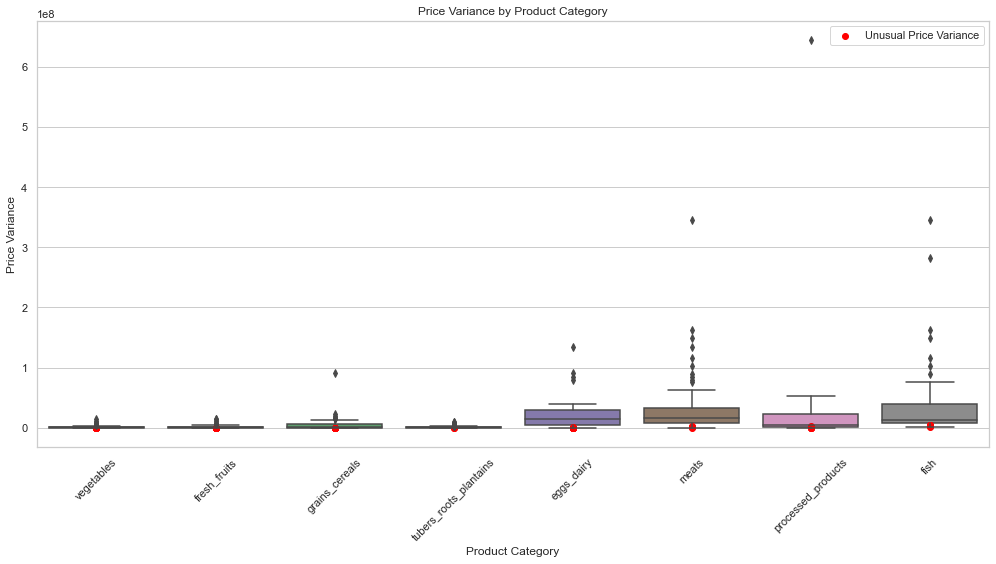

In [79]:
query = """
SELECT 
    pn.english_product AS product,
    cn.english_category AS category,
    pp.ciudad AS city,
    AVG(pp.precio_medio) AS avg_price,
    pp.anho AS year,
    pp.semana_no AS week,
    date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) as date
FROM 
    product_prices pp
LEFT JOIN 
    product_names pn ON pp.producto = pn.spanish_product
LEFT JOIN 
    category_names cn ON pp.categoria = cn.spanish_category
GROUP BY 
    pn.english_product, cn.english_category, pp.ciudad, pp.anho, pp.semana_no
ORDER BY 
    pn.english_product, cn.english_category, pp.anho, pp.semana_no;


"""
df = run.queries_on_rds(query = query)

# Calculate variance for each product over time
price_variance = df.groupby('product')['avg_price'].var().reset_index()
price_variance.columns = ['product', 'price_variance']

# Merge variance data with category information
df_with_variance = df[['product', 'category']].drop_duplicates().merge(price_variance, on='product')

# Calculate average variance per category
category_avg_variance = df_with_variance.groupby('category')['price_variance'].mean().reset_index()
category_avg_variance.columns = ['category', 'avg_category_variance']

# Merge category average variance back into the DataFrame
df_with_variance = df_with_variance.merge(category_avg_variance, on='category')

# Identify products with significantly lower variance compared to the average variance of their category
df_with_variance['unusual_variance'] = df_with_variance['price_variance'] < (0.1 * df_with_variance['avg_category_variance'])

# Filter products with unusual variance
unusual_products = df_with_variance[df_with_variance['unusual_variance']]

# Print the unusual products
print("Products with unusually low price variance:")
print(unusual_products[['product', 'category', 'price_variance']])

# Plotting for better visualization
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_with_variance, x='category', y='price_variance')
plt.scatter(
    unusual_products['category'], 
    unusual_products['price_variance'], 
    color='red', 
    label='Unusual Price Variance'
)
plt.title('Price Variance by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Price Variance')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Price Extremes and Anomalies

#### Are there any anomalies in pricing data where products exhibit unusually high or low prices relative to other products in the same category?


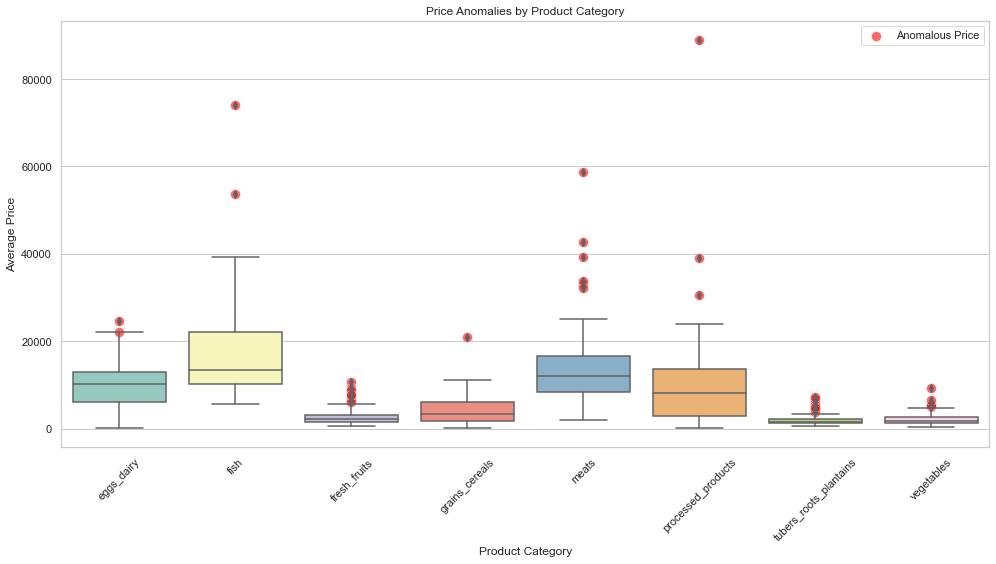

In [90]:
query = """
WITH product_avg_prices AS (
    SELECT 
        pn.english_product AS product,
        cn.english_category AS category,
        AVG(pp.precio_medio) AS avg_price
    FROM product_prices pp
    LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
    LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
    GROUP BY pn.english_product, cn.english_category
),
category_statistics AS (
    SELECT 
        category,
        AVG(avg_price) AS category_avg_price,
        STDDEV(avg_price) AS category_std_dev,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_price) AS category_median,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY avg_price) AS category_q1,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY avg_price) AS category_q3
    FROM product_avg_prices
    GROUP BY category
)
SELECT 
    p.product,
    p.category,
    p.avg_price,
    c.category_avg_price,
    c.category_std_dev,
    c.category_median,
    c.category_q1,
    c.category_q3
FROM product_avg_prices p
JOIN category_statistics c ON p.category = c.category
ORDER BY p.category, p.product;


"""

df = run.queries_on_rds(query = query)


# Identify anomalies using Z-score method (price deviation from category mean)
df['z_score'] = (df['avg_price'] - df['category_avg_price']) / df['category_std_dev']
df['is_anomalous_z'] = (df['z_score'].abs() > 2)  # Products with Z-score greater than 2 are considered anomalies

# Identify anomalies using IQR method (price deviation from category median)
iqr = df['category_q3'] - df['category_q1']
df['lower_bound'] = df['category_q1'] - 1.5 * iqr
df['upper_bound'] = df['category_q3'] + 1.5 * iqr
df['is_anomalous_iqr'] = (df['avg_price'] < df['lower_bound']) | (df['avg_price'] > df['upper_bound'])

# Combine both anomaly columns to flag any anomalies
df['is_anomalous'] = df['is_anomalous_z'] | df['is_anomalous_iqr']

# Filter anomalies
anomalous_products = df[df['is_anomalous']]

# Plot anomalies using seaborn
plt.figure(figsize=(14, 8))
sns.boxplot(x='category', y='avg_price', data=df, palette='Set3')

# Overlay anomalies
sns.scatterplot(x='category', y='avg_price', data=anomalous_products, color='red', s=100, label='Anomalous Price', alpha=0.6)

plt.xticks(rotation=45)
plt.title('Price Anomalies by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
anomalous_products

,product,category,avg_price,category_avg_price,category_std_dev,category_median,category_q1,category_q3,z_score,is_anomalous_z,lower_bound,upper_bound,is_anomalous_iqr,is_anomalous
34,fine_loin,eggs_dairy,22141.136364,9436.069638,5770.807989,10330.683333,6111.476190,12902.736500,2.201610,True,-4075.414273,23089.626964,False,True
50,powdered_milk,eggs_dairy,24630.176706,9436.069638,5770.807989,10330.683333,6111.476190,12902.736500,2.632925,True,-4075.414273,23089.626964,True,True
92,shrimp_16-20,fish,53669.030111,18377.512090,13327.629630,13347.607112,10254.238205,22126.819641,2.647997,True,-7554.633948,39935.691794,True,True
97,u12_shrimp,fish,74163.314419,18377.512090,13327.629630,13347.607112,10254.238205,22126.819641,4.185726,True,-7554.633948,39935.691794,True,True
112,chilean_black_plum,fresh_fruits,6523.241121,2890.721949,2061.748569,2323.253324,1523.304948,3184.495976,1.761863,False,-968.481595,5676.282518,True,True
134,imported_black_plum,fresh_fruits,7055.428571,2890.721949,2061.748569,2323.253324,1523.304948,3184.495976,2.019988,True,-968.481595,5676.282518,True,True
135,imported_grape,fresh_fruits,10626.891595,2890.721949,2061.748569,2323.253324,1523.304948,3184.495976,3.752237,True,-968.481595,5676.282518,True,True
136,imported_green_apple,fresh_fruits,6016.102986,2890.721949,2061.748569,2323.253324,1523.304948,3184.495976,1.515889,False,-968.481595,5676.282518,True,True
137,imported_peach,fresh_fruits,7924.487949,2890.721949,2061.748569,2323.253324,1523.304948,3184.495976,2.441503,True,-968.481595,5676.282518,True,True
139,imported_plum,fresh_fruits,9331.229526,2890.721949,2061.748569,2323.253324,1523.304948,3184.495976,3.123808,True,-968.481595,5676.282518,True,True


- Categories like fish, meats, and eggs_dairy clearly exhibit significant outliers.
- The processed products and meats categories seem to have a wider range of price fluctuations, indicating higher volatility compared to others like grains_cereals and tubers_roots_plantains.
- It appears that eggs_dairy and fish have outliers with unusually high average prices, which might indicate supply chain disruptions, increased demand, or some external influence (like climate effects for fish).
- Vegetables seem to have fewer anomalies and a relatively stable price pattern. This stability could indicate consistent supply, minimal production risk, or a well-distributed demand.

#### How frequent are extreme price changes (sharp increases or drops), and which product categories are more prone to these shifts?


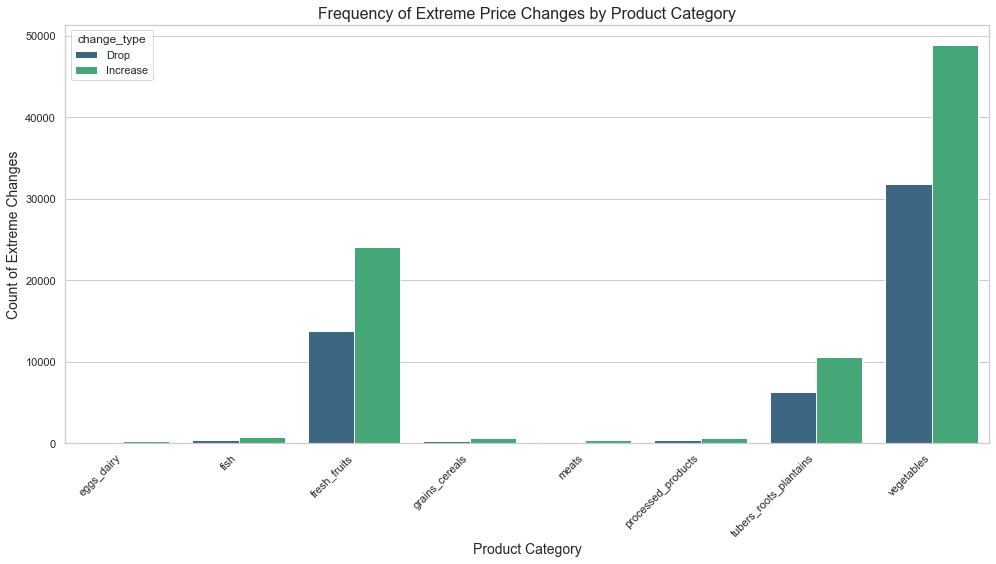

In [96]:

query = """
      WITH weekly_avg AS (
    SELECT
        pn.english_product AS product,
        cn.english_category AS category,
        pp.ciudad AS city,
        pp.anho AS year,
        pp.semana_no AS week,
        AVG(pp.precio_medio) AS avg_price,
        date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) AS date
    FROM
        product_prices pp
    LEFT JOIN
        product_names pn ON pp.producto = pn.spanish_product
    LEFT JOIN
        category_names cn ON pp.categoria = cn.spanish_category
    GROUP BY
        pn.english_product, cn.english_category, pp.ciudad, pp.anho, pp.semana_no
    ORDER BY
        pn.english_product, cn.english_category, pp.anho, pp.semana_no
),
price_change AS (
    SELECT
        product,
        category,
        city,
        date,
        avg_price,
        LAG(avg_price) OVER (PARTITION BY product, city ORDER BY date) AS previous_avg_price,
        -- Calculate percentage change, handle division by zero
        CASE
            WHEN LAG(avg_price) OVER (PARTITION BY product, city ORDER BY date) IS NOT NULL
            AND LAG(avg_price) OVER (PARTITION BY product, city ORDER BY date) <> 0
            THEN (avg_price - LAG(avg_price) OVER (PARTITION BY product, city ORDER BY date)) /
                 LAG(avg_price) OVER (PARTITION BY product, city ORDER BY date) * 100
            ELSE NULL
        END AS percentage_change
    FROM
        weekly_avg
)
-- Filter for extreme changes (greater than +20pc or less than -20pc)
SELECT
    product,
    category,
    city,
    date,
    avg_price,
    percentage_change
FROM
    price_change
WHERE
    percentage_change IS NOT NULL
    AND ABS(percentage_change) > 20  
ORDER BY
    category, product, date;

"""

# Retrieve the query result as a DataFrame
extreme_changes_df = run.queries_on_rds(query=query)

# Create a new column for the type of extreme change
extreme_changes_df['change_type'] = extreme_changes_df['percentage_change'].apply(lambda x: 'Increase' if x > 0 else 'Drop')

# Plot the frequency of extreme changes by product category
plt.figure(figsize=(14, 8))
sns.countplot(data=extreme_changes_df, x='category', hue='change_type', palette='viridis')

# Add titles and labels to the plot
plt.title('Frequency of Extreme Price Changes by Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Count of Extreme Changes', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

1. Vegetables:

- Vegetables exhibit the highest frequency of extreme price changes overall, with a significantly larger number of sharp increases in price compared to decreases.
- This suggests that vegetables are highly susceptible to external factors like seasonality, weather conditions, or supply chain issues that may cause frequent and large fluctuations in prices.

2. Fresh Fruits:

- Fresh fruits also show a high number of extreme price changes, though with a more balanced count between price increases and price drops.
- This pattern may indicate volatility caused by similar factors as vegetables—like perishability, supply chain interruptions, and seasonal availability—but the equal distribution between increases and drops suggests frequent fluctuations in both directions.

3. Grains & Cereals:

- Grains and cereals have a notable number of extreme price increases, with fewer price drops.
- The pattern here may indicate structural shifts in supply or demand, potentially driven by inflationary pressures, changes in global commodity markets, or supply chain disruptions.

4. Tubers, Roots, and Plantains:

- This category also shows frequent price fluctuations, both increases and decreases, indicating some level of instability.

5. Fish, Meats, Processed Products, and Eggs/Dairy:

- Fish, meats, processed products, and eggs/dairy exhibit significantly fewer extreme price changes.
- The lower frequency of extreme changes in these categories may suggest more stable supply chains or less sensitivity to external shocks compared to vegetables and fresh fruits.
- This could also reflect that these products are either less perishable (processed products) or are produced in more controlled conditions (such as eggs/dairy from farms).

Highly Volatile Categories:

- Vegetables and fresh fruits are clearly the most volatile categories in terms of extreme price changes. This is likely due to their sensitivity to seasonal changes, climate variations, and perishability.

Relatively Stable Categories:

- Processed products and dairy exhibit more stability in pricing, which may be due to less reliance on raw, perishable ingredients and better control over the production and supply chain.

Supply Chain and Market Factors:

- The significant number of price increases in grains and cereals might indicate long-term supply chain challenges or inflationary pressures affecting staple goods.

### Market-Specific Insights

#### Do certain marketplaces exhibit unique pricing trends that differ from other locations?

<Figure size 1080x720 with 0 Axes>

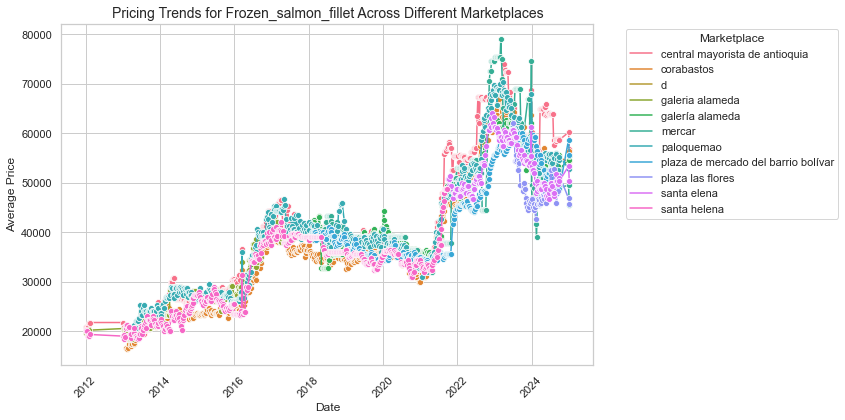

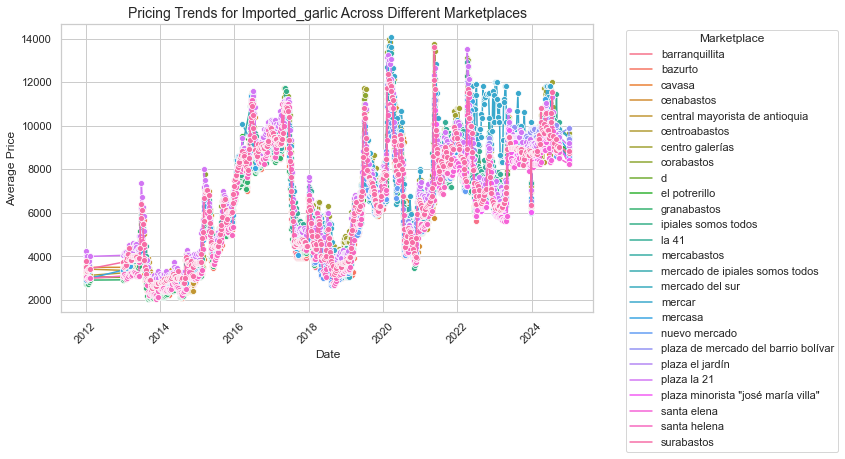

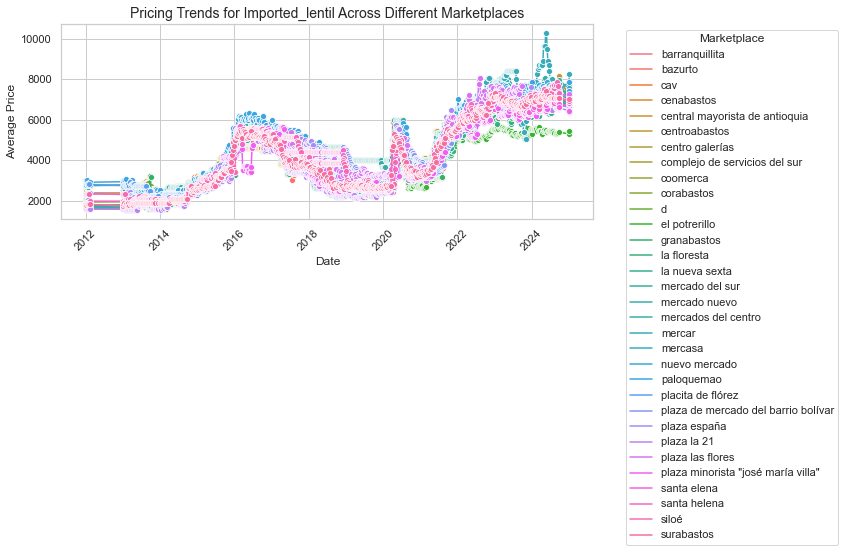

In [8]:
query = """
      -- SQL Query to extract pricing trends for different marketplaces
SELECT 
    pn.english_product AS product,
    pp.mercado AS marketplace,
    AVG(pp.precio_medio) AS avg_price,
    pp.anho AS year,
    pp.semana_no AS week,
    date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) as date
FROM product_prices pp
LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
WHERE pn.english_product IN ('frozen_salmon_fillet', 'imported_garlic', 'imported_lentil')  -- Choose representative products
GROUP BY pn.english_product, pp.mercado, pp.anho, pp.semana_no
ORDER BY pn.english_product, pp.mercado, pp.anho, pp.semana_no;


"""
df_marketplaces = run.queries_on_rds(query=query)


# Convert the 'date' column to datetime format
df_marketplaces['date'] = pd.to_datetime(df_marketplaces['date'])

# Plot price trends for each product, split by marketplaces
products = df_marketplaces['product'].unique()

# Set up the figure size and styling
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Loop through each product to create separate plots for better visualization
for product in products:
    plt.figure(figsize=(12, 6))
    subset = df_marketplaces[df_marketplaces['product'] == product]
    sns.lineplot(data=subset, x='date', y='avg_price', hue='marketplace', marker='o')
    
    # Add plot title and labels
    plt.title(f'Pricing Trends for {product.capitalize()} Across Different Marketplaces', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Marketplace', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



1. Price Trend Consistency:

- The graphs reveal how the average prices of specific products vary across multiple marketplaces over time.
- For each product, different marketplaces follow relatively similar trends but still show deviations, which could indicate variations in local supply and demand dynamics or potential monopolistic/oligopolistic behavior.
- For "Frozen Salmon Fillet," some marketplaces show consistently higher prices compared to others. This might imply that certain markets are driving up prices, possibly due to less competition or higher demand in those regions.

2. Price Discrepancies:

- In both plots, we see noticeable price discrepancies for certain time periods. For instance:
- In the case of "Frozen Salmon Fillet," some marketplaces have price peaks that are considerably higher during specific periods, indicating that price volatility is not uniform across marketplaces.
- "Imported Garlic" has similar peaks across the marketplaces, but there are also periods where specific marketplaces deviate significantly from the rest.

3. Implications:

 Monopolistic/Oligopolistic Behavior:
- If a particular marketplace consistently shows higher prices for a product (compared to others) even when the trends generally align, this could be evidence of monopolistic or oligopolistic control. For example, a lack of competitors in that market may allow vendors to set higher prices.
- Marketplaces that show significant peaks that others do not could imply local disruptions or a lack of price controls, further hinting at monopolistic behavior.

4. Market-Specific Pricing Strategies:

- Another interpretation is that each marketplace might have its own pricing strategy. For instance, marketplaces with higher prices might cater to a more premium customer segment or incur higher logistical costs. This variation itself could point towards differences in competition or target demographics.

#### Is there evidence of monopolistic or oligopolistic behavior in certain markets, where prices in one marketplace consistently trend above or below the national average?


In [66]:
query = """
WITH category_avg AS (
    SELECT 
        cn.english_category AS category,
        AVG(pp.precio_medio) AS national_avg_price,
        pp.anho AS year,
        pp.semana_no AS week,
        date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) AS date
    FROM product_prices pp
    LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
    GROUP BY cn.english_category, pp.anho, pp.semana_no
)
SELECT 
    cn.english_category AS category,
    pp.mercado,
    AVG(pp.precio_medio) AS avg_price,
    ca.national_avg_price,
    pp.anho AS year,
    pp.semana_no AS week,
    date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) AS date
FROM product_prices pp
LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
JOIN category_avg ca ON cn.english_category = ca.category AND pp.anho = ca.year AND pp.semana_no = ca.week
GROUP BY cn.english_category, pp.mercado, ca.national_avg_price, pp.anho, pp.semana_no
ORDER BY cn.english_category, pp.mercado, pp.anho, pp.semana_no;



"""
df_marketplaces  = run.queries_on_rds(query=query)


In [67]:
df_marketplaces

,category,mercado,avg_price,national_avg_price,year,week,date
0,eggs_dairy,barranquillita,12615.500000,5330.857143,2012,1,2012-01-01 00:00:00+00:00
1,eggs_dairy,barranquillita,12918.000000,5414.400000,2012,2,2012-01-08 00:00:00+00:00
2,eggs_dairy,barranquillita,13084.500000,5804.201389,2012,3,2012-01-15 00:00:00+00:00
3,eggs_dairy,barranquillita,13054.500000,5896.604167,2012,4,2012-01-22 00:00:00+00:00
4,eggs_dairy,barranquillita,12821.000000,5705.437086,2012,5,2012-01-29 00:00:00+00:00
...,...,...,...,...,...,...,...
125139,vegetables,None,2782.964912,2900.483624,2024,40,2024-09-30 00:00:00+00:00
125140,vegetables,None,2892.875433,3011.330803,2024,41,2024-10-07 00:00:00+00:00
125141,vegetables,None,2907.427586,3032.181325,2024,42,2024-10-14 00:00:00+00:00
125142,vegetables,None,2974.081181,3198.089744,2024,53,2024-12-30 00:00:00+00:00


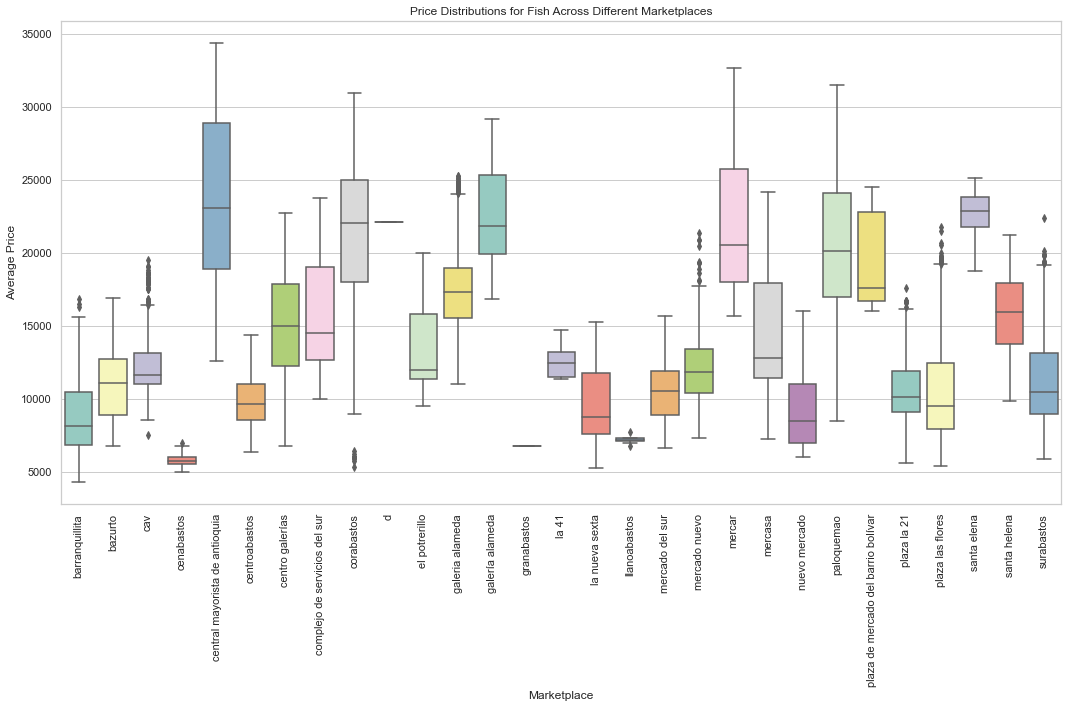

In [74]:
query = """
WITH category_avg AS (
    SELECT 
        cn.english_category AS category,
        AVG(pp.precio_medio) AS national_avg_price,
        pp.anho AS year,
        pp.semana_no AS week,
        date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) AS date
    FROM product_prices pp
    LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
    GROUP BY cn.english_category, pp.anho, pp.semana_no
)
SELECT 
    cn.english_category AS category,
    pp.mercado,
    AVG(pp.precio_medio) AS avg_price,
    ca.national_avg_price,
    pp.anho AS year,
    pp.semana_no AS week,
    date_trunc('year', to_date(anho::text, 'YYYY')) + interval '1 week' * (semana_no - 1) AS date
FROM product_prices pp
LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
JOIN category_avg ca ON cn.english_category = ca.category AND pp.anho = ca.year AND pp.semana_no = ca.week
GROUP BY cn.english_category, pp.mercado, ca.national_avg_price, pp.anho, pp.semana_no
ORDER BY cn.english_category, pp.mercado, pp.anho, pp.semana_no;



"""
# df_marketplaces  = run.queries_on_rds(query=query)

plt.figure(figsize=(15, 10))
sns.boxplot(data=subset, x='mercado', y='avg_price', palette="Set3")

plt.title(f'Price Distributions for {category_to_analyze.capitalize()} Across Different Marketplaces')
plt.xlabel('Marketplace')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


1. Price Variability Across Marketplaces:

- There is significant variability in fish prices across different marketplaces.
- Some marketplaces, like central mayorista de antioquia and nueva sexta, show a wider interquartile range (IQR) and higher price variance. This suggests that prices in these marketplaces fluctuate more compared to others.
- Marketplaces such as cav and cenabastos show a very narrow price range, indicating more stable pricing or potentially consistent supply and demand.

2. Median Price Differences:

- The median prices (indicated by the horizontal line within each box) differ quite substantially across marketplaces.
- Marketplaces like mercado del sur and mercado nuevo have higher median prices compared to others like cenabastos or plaza la 21, which have lower median prices. This implies that fish in certain locations are consistently more expensive, potentially due to location, supply chain costs, or demand differences.

3. Presence of Outliers:

- Several marketplaces exhibit outliers, shown as individual dots beyond the whiskers of the box. These outliers represent unusually high or low prices.
- Marketplaces like mercasa, nuevo mercado, and plaza de mercado del barrio bolívar show significant outliers on the high end, indicating occasional price spikes.
- Conversely, a marketplace like bazurto has an outlier on the low end, suggesting a temporary dip in prices.

4. Consistency vs. Instability:

- Marketplaces such as bazurto and plaza la 21 exhibit lower variability and a tight box, indicating stable prices with fewer fluctuations over time.
- On the other hand, central mayorista de antioquia and mercasa display more variation, both in terms of IQR and outliers, suggesting less predictable and more unstable pricing.

5. Potential Market Factors:

- The differences in price variability could suggest differing market structures or supply chain dynamics. Marketplaces with lower price variability may have more reliable supply chains or more competitive market forces keeping prices consistent.
- Marketplaces with high variability or frequent outliers may be affected by seasonality, supply issues, or monopolistic/oligopolistic behavior, where a few suppliers dominate and control prices.

### Relationship Between Price Trends and Trends Column



#### How does the "trend" column (which indicates price change directions) align with the actual price changes over time?


Overall Accuracy of Trend Column: 20.63%


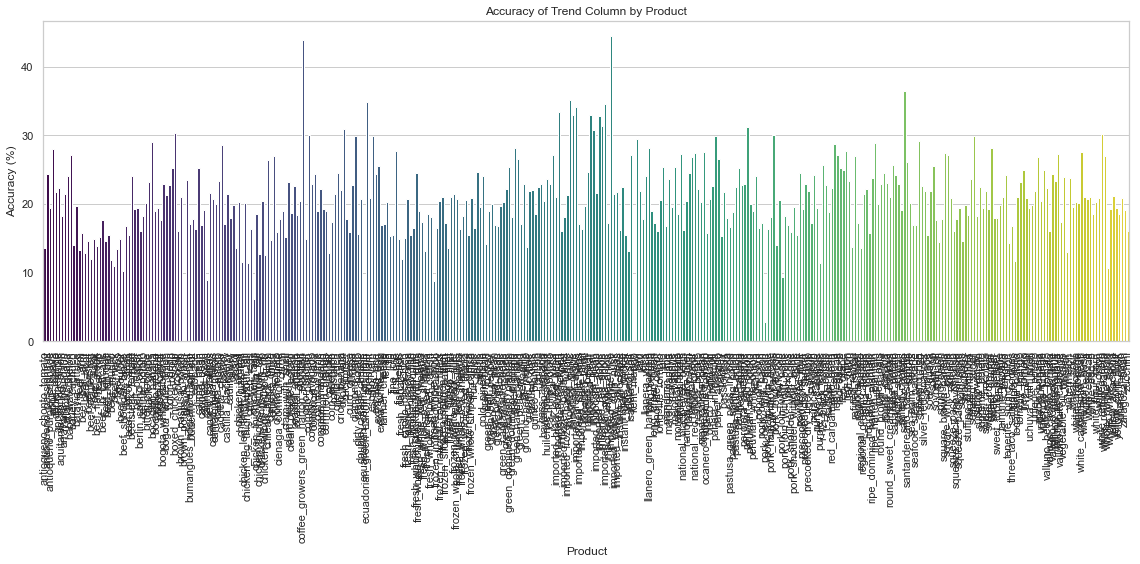

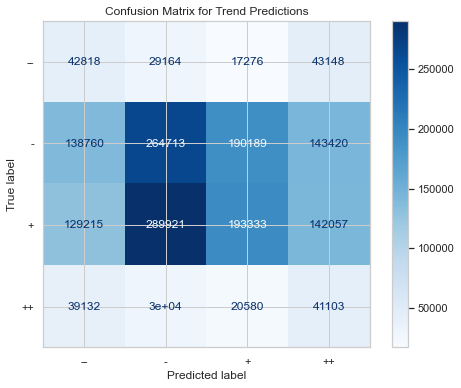

In [75]:
query = """
WITH price_changes AS (
    SELECT 
        pn.english_product AS product,
        pp.ciudad AS city,
        pp.anho AS year,
        pp.semana_no AS week,
        date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) AS date,
        pp.precio_medio AS mean_price,
        pp.tendencia AS trend
    FROM 
        product_prices pp
    LEFT JOIN 
        product_names pn ON pp.producto = pn.spanish_product
    ORDER BY 
        pn.english_product, city, date
)
SELECT 
    product,
    city,
    date,
    mean_price,
    trend,
    LEAD(mean_price) OVER (PARTITION BY product, city ORDER BY date) AS next_mean_price
FROM 
    price_changes;




"""
df_trend  = run.queries_on_rds(query=query)

df_trend.dropna(subset=['next_mean_price'], inplace=True)

# Calculate the actual price change direction
df_trend['actual_change'] = df_trend['next_mean_price'] - df_trend['mean_price']
df_trend['actual_trend'] = np.where(df_trend['actual_change'] > 0, '+', '-')
df_trend['actual_trend'] = np.where(df_trend['actual_change'] > 0.05 * df_trend['mean_price'], '++', df_trend['actual_trend'])
df_trend['actual_trend'] = np.where(df_trend['actual_change'] < -0.05 * df_trend['mean_price'], '--', df_trend['actual_trend'])

# Compare the actual trend with the trend column to evaluate accuracy
df_trend['correct_prediction'] = df_trend['trend'] == df_trend['actual_trend']

# Calculate overall accuracy
overall_accuracy = df_trend['correct_prediction'].mean() * 100

# Print overall accuracy
print(f"Overall Accuracy of Trend Column: {overall_accuracy:.2f}%")

# Plot accuracy by product
accuracy_by_product = df_trend.groupby('product')['correct_prediction'].mean().reset_index()
accuracy_by_product['accuracy'] = accuracy_by_product['correct_prediction'] * 100

plt.figure(figsize=(16, 8))
sns.barplot(data=accuracy_by_product, x='product', y='accuracy', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Trend Column by Product')
plt.tight_layout()
plt.show()

# Optional: Plotting confusion matrix-like results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prepare labels
labels = ['--', '-', '+', '++']
conf_matrix = confusion_matrix(df_trend['trend'], df_trend['actual_trend'], labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Trend Predictions')
plt.show()

- The visualizations show that the current approach of using the trend column is not particularly effective for most products. This is evident from both the low accuracy percentage across many products and the confusion matrix, which indicates significant confusion between predicted and actual values.

- For certain products, the trend column appears to be a more reliable predictor, implying that the effectiveness of this method may depend on specific product categories or underlying price behaviors. Understanding these characteristics could help refine the trend assignment approach.

- It may be beneficial to shift away from relying solely on the trend column and instead use it as one feature among many for a more sophisticated prediction model. Developing a model that takes into account both historical pricing and other market factors could lead to better predictions of price movements.

#### Are the directional indicators (++, +, -, etc.) accurate predictors of future price movement?

Overall Accuracy of Trend Indicators: 44.19%


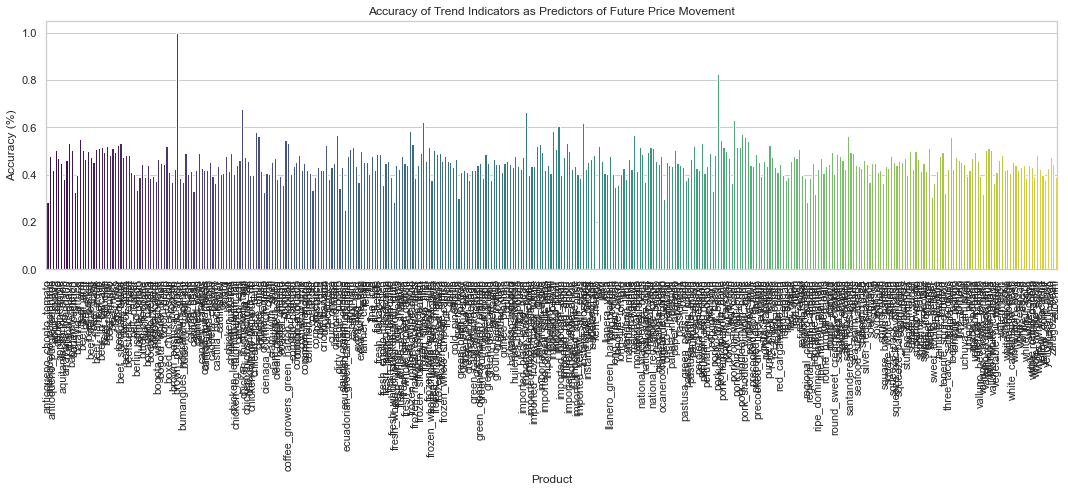

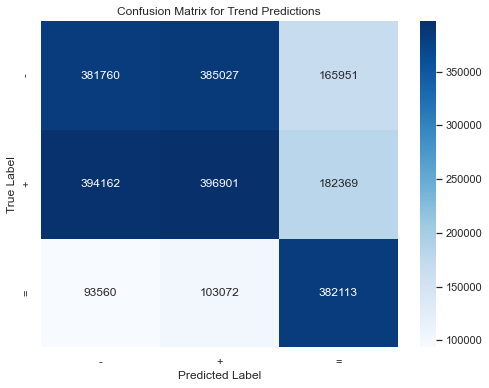

In [81]:
query = """
WITH price_data AS (
    SELECT 
        pn.english_product AS product,
        pp.ciudad AS city,
        pp.tendencia AS trend_indicator,
        pp.precio_medio AS current_price,
        LEAD(pp.precio_medio, 1) OVER (PARTITION BY pn.english_product, pp.ciudad ORDER BY pp.anho, pp.semana_no) AS next_week_price,
        pp.anho AS year,
        pp.semana_no AS week
    FROM 
        product_prices pp
    LEFT JOIN 
        product_names pn ON pp.producto = pn.spanish_product
    WHERE 
        pp.tendencia IS NOT NULL
)
SELECT 
    product,
    city,
    year,
    week,
    trend_indicator,
    current_price,
    next_week_price,
    CASE
        WHEN next_week_price > current_price THEN '+'
        WHEN next_week_price < current_price THEN '-'
        ELSE '='
    END AS actual_movement
FROM 
    price_data
WHERE 
    next_week_price IS NOT NULL
ORDER BY 
    product, city, year, week;



"""
# df_trend  = run.queries_on_rds(query=query)

# Map trend indicators for simplification (++, +, -, --)
indicator_map = {
    '++': '+',
    '--': '-',
    '=': '='  # Assuming a stable trend is represented with '='
}

# Simplify trend_indicator to '+', '-', '=' for comparison with actual_movement
df_trend['simplified_trend'] = df_trend['trend_indicator'].replace(indicator_map)

# Calculate Accuracy
accuracy = accuracy_score(df_trend['simplified_trend'], df_trend['actual_movement'])
print(f"Overall Accuracy of Trend Indicators: {accuracy * 100:.2f}%")

# Plotting Accuracy by Product
accuracy_by_product = df_trend.groupby('product').apply(
    lambda x: accuracy_score(x['simplified_trend'], x['actual_movement'])
)

# Plotting the accuracy per product
plt.figure(figsize=(15, 7))
sns.barplot(x=accuracy_by_product.index, y=accuracy_by_product.values, palette="viridis")
plt.title('Accuracy of Trend Indicators as Predictors of Future Price Movement')
plt.xlabel('Product')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Confusion Matrix for a better understanding of misclassifications
cm = confusion_matrix(df_trend['actual_movement'], df_trend['simplified_trend'], labels=['-', '+', '='])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['-', '+', '='], yticklabels=['-', '+', '='])
plt.title('Confusion Matrix for Trend Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The results suggest that current trend indicators do not adequately predict future price movements across many products. The confusion matrix and accuracy plot highlight widespread misclassifications and low predictive power for many items. 

## product affordability

In [91]:
query = """
WITH product_price AS (
    SELECT 
        pp.ciudad AS city, 
        pn.english_product AS product, 
        AVG(pp.precio_medio) AS avg_price, 
        pp.anho AS year, 
        date_trunc('year', to_date(pp.anho::text, 'YYYY')) + interval '1 week' * (pp.semana_no - 1) AS date
    FROM product_prices pp
    LEFT JOIN product_names pn ON pp.producto = pn.spanish_product
    LEFT JOIN category_names cn ON pp.categoria = cn.spanish_category
    WHERE cn.english_category = 'meats'
    AND pp.ciudad = 'bogota'
    GROUP BY pp.ciudad, pn.english_product, pp.anho, pp.semana_no
),
income_data AS (
    SELECT city, year, AVG(monthly_income) AS avg_income
    FROM min_wages
    GROUP BY city, year
),
recent_data AS (
    -- Filter for records from the last 60 days
    SELECT *
    FROM product_price
    WHERE date >= CURRENT_DATE - INTERVAL '60 days'
),
affordability_data AS (
    SELECT 
        p.city, 
        p.product, 
        AVG(p.avg_price) AS avg_price,  -- Average price for each product over the last 60 days
        AVG(i.avg_income) AS avg_income,  -- Average income over the last 60 days (in case income varies)
        MAX(p.date) AS recent_date,  -- The most recent date for the product record
        (AVG(p.avg_price) / (AVG(i.avg_income) / 4)) * 100 AS affordability_index  -- Percentage of weekly income required to buy a unit
    FROM recent_data p
    JOIN income_data i 
        ON p.city = i.city AND p.year = i.year
    GROUP BY p.city, p.product
)
SELECT 
    city, 
    product, 
    avg_price, 
    avg_income, 
    recent_date, 
    affordability_index,
    RANK() OVER (PARTITION BY city ORDER BY affordability_index ASC) AS affordability_rank
FROM affordability_data
ORDER BY city, affordability_rank;

"""

dataframe = run.queries_on_rds(query=query)

In [92]:
dataframe

,city,product,avg_price,avg_income,recent_date,affordability_index,affordability_rank
0,bogota,chicken_wings_with_rib,8421.883333,1300000.0,2025-01-06 00:00:00+00:00,2.591349,1
1,bogota,chicken_leg_thigh_with_tail,10306.416667,1300000.0,2025-01-06 00:00:00+00:00,3.171205,2
2,bogota,chicken_wings_without_rib,10830.630000,1300000.0,2025-01-06 00:00:00+00:00,3.332502,3
3,bogota,chicken_thighs_without_tail,11707.360000,1300000.0,2025-01-06 00:00:00+00:00,3.602265,4
4,bogota,fresh_whole_chicken_without_guts,11910.650000,1300000.0,2025-01-06 00:00:00+00:00,3.664815,5
5,bogota,chicken_leg_thigh_without_tail,12082.000000,1300000.0,2025-01-06 00:00:00+00:00,3.717538,6
6,bogota,chicken_legs,12646.980000,1300000.0,2025-01-06 00:00:00+00:00,3.891378,7
7,bogota,pork_in_carcass,13188.375000,1300000.0,2025-01-06 00:00:00+00:00,4.057962,8
8,bogota,pork_jowl_bacon,15669.150000,1300000.0,2025-01-06 00:00:00+00:00,4.821277,9
9,bogota,chicken_breast,15765.500000,1300000.0,2025-01-06 00:00:00+00:00,4.850923,10


In [90]:
city_data['date'].max()

Timestamp('2025-01-06 00:00:00+0000', tz='UTC')

In [86]:
bottom_10_products

,city,product,avg_price,avg_income,date,affordability_index,affordability_rank
22965,bogota,fine_loin,43083.333333,1000000.0,2022-07-23 00:00:00+00:00,17.233333,22966
22966,bogota,fine_loin,43083.333333,1000000.0,2022-08-20 00:00:00+00:00,17.233333,22966
22967,bogota,fine_loin,43166.666667,1000000.0,2022-06-11 00:00:00+00:00,17.266667,22968
22968,bogota,fine_loin,43166.666667,1000000.0,2022-06-25 00:00:00+00:00,17.266667,22968
22969,bogota,fine_loin,43250.000000,1000000.0,2022-07-30 00:00:00+00:00,17.300000,22970
22970,bogota,fine_loin,43389.000000,1000000.0,2022-07-16 00:00:00+00:00,17.355600,22971
22971,bogota,fine_loin,43583.333333,1000000.0,2022-07-02 00:00:00+00:00,17.433333,22972
22972,bogota,fine_loin,43944.333333,1000000.0,2022-08-06 00:00:00+00:00,17.577733,22973
22973,bogota,national_hake_fillet,34500.000000,781242.0,2018-01-22 00:00:00+00:00,17.664181,22974
22974,bogota,frozen_salmon_fillet,38625.000000,781242.0,2018-01-22 00:00:00+00:00,19.776203,22975


In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_product_affordability_rank(dataframe: pd.DataFrame, city: str):
    """
    Plots a bar chart to visualize the ranking of products based on affordability in a specific city.

    Args:
        dataframe (pd.DataFrame): Dataframe containing columns 'city', 'product', 'affordability_index', and 'affordability_rank'.
        city (str): The city for which to visualize the product affordability ranking.
    """
    # Filter the dataframe for the specified city
    city_data = dataframe[dataframe['city'] == city].sort_values(by='affordability_rank')

    # Set up the figure size and style
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Plot the data
    sns.barplot(data=city_data, x='affordability_index', y='product', palette='viridis', order=city_data['product'])
    
    # Add titles and labels
    plt.title(f'Product Affordability Ranking in {city.title()}', fontsize=20, weight='bold')
    plt.xlabel('Affordability Index (% of Weekly Income)', fontsize=14)
    plt.ylabel('Product', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [9]:
run.log_files_manager()

['logs/sipsa_process_10_02_2024.log',
 'logs/sipsa_process_10_04_2024.log',
 'logs/sipsa_process_10_05_2024.log',
 'logs/sipsa_process_10_06_2024.log',
 'logs/sipsa_process_10_07_2024.log',
 'logs/sipsa_process_10_08_2024.log',
 'logs/sipsa_process_10_09_2024.log',
 'logs/sipsa_process_10_10_2024.log',
 'logs/sipsa_process_10_11_2024.log',
 'logs/sipsa_process_10_12_2024.log',
 'logs/sipsa_process_10_13_2024.log',
 'logs/sipsa_process_10_14_2024.log',
 'logs/sipsa_process_10_15_2024.log',
 'logs/sipsa_process_10_16_2024.log',
 'logs/sipsa_process_10_17_2024.log',
 'logs/sipsa_process_10_18_2024.log',
 'logs/sipsa_process_10_19_2024.log',
 'logs/sipsa_process_10_20_2024.log',
 'logs/sipsa_process_10_21_2024.log',
 'logs/sipsa_process_10_22_2024.log',
 'logs/sipsa_process_10_23_2024.log',
 'logs/sipsa_process_10_24_2024.log',
 'logs/sipsa_process_10_25_2024.log',
 'logs/sipsa_process_10_26_2024.log',
 'logs/sipsa_process_10_27_2024.log',
 'logs/sipsa_process_10_28_2024.log',
 'logs/sipsa

In [5]:
# run.log_files_manager(log_file = 'logs/sipsa_process_10_07_2024.log')

#### Do imported products (e.g., "imported_frozen_basa_fillet") have different price trends compared to locally sourced products (e.g., bananas or avocados)?


## Util functions

### DataPipelineManager

In [1]:
# import boto3
# import os
# import pandas as pd
# from dotenv import load_dotenv
# from io import BytesIO
# from sqlalchemy import create_engine
# from botocore.exceptions import ClientError

# class DataPipelineManager:
#     def __init__(self):
#         """
#         Initializes the DataPipelineManager class, loading environment variables and setting up S3 and RDS connections.
#         """
#         load_dotenv()

#         # Initialize AWS credentials
#         self.aws_access_key_id = os.environ['aws_access_key_id']
#         self.aws_secret_access_key = os.environ['aws_secret_access_key']
#         self.bucket_name = os.environ['BUCKET_NAME']
        
#         # Initialize S3 resource
#         self.s3 = boto3.resource('s3',
#                                 aws_access_key_id=self.aws_access_key_id, 
#                                 aws_secret_access_key=self.aws_secret_access_key)

#         # Initialize RDS database credentials
#         self.db_user = os.environ['db_user']
#         self.db_pass = os.environ['db_pass']
#         self.db_host = os.environ['db_host']
#         self.db_port = os.environ['db_port']
#         self.db_name = os.environ['db_name']
#         self.engine = create_engine(f'postgresql://{self.db_user}:{self.db_pass}@{self.db_host}:{self.db_port}/{self.db_name}')
    
#     def queries_on_rds(self, query: str) -> pd.DataFrame:
#         """
#         Executes a SQL query on the RDS PostgreSQL database and returns the result as a pandas DataFrame.

#         Args:
#             query (str): The SQL query to execute.

#         Returns:
#             pd.DataFrame: The result of the SQL query.
#         """
#         with self.engine.begin() as conn:
#             dataframe = pd.read_sql(sql=query, con=conn)
#         return dataframe

#     def get_files_tracker_from_s3(self, file_name: str = 'files_tracker.csv') -> pd.DataFrame:
#         """
#         Retrieves the 'files_tracker.csv' from the S3 bucket and returns its content as a pandas DataFrame.

#         Args:
#             file_name (str): The name of the file to retrieve from S3.

#         Returns:
#             pd.DataFrame: The content of the file as a pandas DataFrame.
#         """
#         try:
#             obj = self.s3.Object(self.bucket_name, file_name)
#             csv_content = obj.get()['Body'].read()
#             df = pd.read_csv(BytesIO(csv_content))
#             return df
#         except ClientError as e:
#             print(f"Error retrieving file from S3: {e}")
#             return pd.DataFrame()

#     def log_files_manager(self, log_file: str = None, log_prefix: str = 'logs/') -> list:
#         """
#         Lists or retrieves log files from the S3 bucket. If a log file is provided, its content is loaded into a pandas DataFrame.

#         Args:
#             log_file (str, optional): The specific log file to retrieve. Defaults to None, in which case all log files are listed.
#             log_prefix (str, optional): The prefix where log files are stored. Defaults to 'logs/'.

#         Returns:
#             list: A list of log file names if log_file is None.
#             pd.DataFrame: The content of the log file as a pandas DataFrame if log_file is provided.
#         """
#         if log_file is None:
#             try:
#                 bucket = self.s3.Bucket(self.bucket_name)
#                 log_files = [obj.key for obj in bucket.objects.filter(Prefix=log_prefix) if obj.key.endswith('.log')]
#                 return log_files
#             except ClientError as e:
#                 print(f"Error listing log files from S3: {e}")
#                 return []
#         else:
#             try:
#                 obj = self.s3.Object(self.bucket_name, log_file)
#                 log_content = obj.get()['Body'].read().decode('utf-8')
#                 log_lines = log_content.splitlines()
#                 log_data = [line.split(' - ', maxsplit=2) for line in log_lines if len(line.split(' - ', maxsplit=2)) == 3]
#                 df = pd.DataFrame(log_data, columns=['timestamp', 'level', 'message'])
#                 return df
#             except ClientError as e:
#                 print(f"Error reading log file {log_file} from S3: {e}")
#                 return pd.DataFrame()

In [6]:
# Example Usage
manager = DataPipelineManager()

In [9]:
manager.get_files_tracker_from_s3()

,file,link,date_added,rds_load
0,week_39_anex-SIPSASemanal-21sep-27sep-2024.xlsx,https://www.dane.gov.co/files/operaciones/SIPS...,2024-10-02,yes
1,week_38_anex-SIPSASemanal-14sep-20sep-2024.xlsx,https://www.dane.gov.co/files/operaciones/SIPS...,2024-10-02,yes
2,week_37_anex-SIPSASemanal-7sep-13sep-2024.xlsx,https://www.dane.gov.co/files/operaciones/SIPS...,2024-10-02,yes
3,week_36_anex-SIPSASemanal-31ago-6sep-2024.xlsx,https://www.dane.gov.co/files/operaciones/SIPS...,2024-10-02,yes
4,week_35_anex-SIPSASemanal-24ago-30ago-2024.xlsx,https://www.dane.gov.co/files/operaciones/SIPS...,2024-10-02,yes
...,...,...,...,...
614,week_4_Anexo_Bol_Semanal_SIPSA_Diciembre_1_201...,https://www.dane.gov.co/files/investigaciones/...,2024-10-02,yes
615,week_3_Anexo_Bol_Semanal_SIPSA_Noviembre_24_20...,https://www.dane.gov.co/files/investigaciones/...,2024-10-02,yes
616,week_2_Anexo_Bol_Semanal_SIPSA_Noviembre_23_20...,https://www.dane.gov.co/files/investigaciones/...,2024-10-02,yes
617,week_1_Anexo_Bol_Semanal_SIPSA_Noviembre_16_20...,https://www.dane.gov.co/files/investigaciones/...,2024-10-02,yes


In [11]:
manager.log_files_manager()

['logs/sipsa_process_10_02_2024.log',
 'logs/sipsa_process_10_04_2024.log',
 'logs/sipsa_process_10_05_2024.log',
 'logs/sipsa_process_10_06_2024.log']

### Data Visualization

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import statsmodels.api as sm

# def lineplot_per_category(dataframe:pd.DataFrame,
#                           numerical_value:str, 
#                           categorical_value:str)->None:
#     # Set a custom color palette
#     custom_palette = sns.color_palette("Paired", n_colors=len(dataframe[f'{categorical_value}'].unique()))  # Example with "husl" palette
#     # Set the style and color palette
#     sns.set(style="dark", palette=custom_palette)

#     # Set up the figure size and background color
#     plt.figure(figsize=(10, 6))
#     plt.gcf().set_facecolor('#f5f5f5')  # Set figure background color (light gray)

#     # Create a lineplot with lowess smoothing for each category
#     for i, categoria in enumerate(dataframe[f'{categorical_value}'].unique()):
#         subset = dataframe[dataframe[f'{categorical_value}'] == categoria]
#         smoothed_values = sm.nonparametric.lowess(subset[f'{numerical_value}'], subset['date'], frac=0.2)  # Smoothing level
#         plt.plot(subset['date'], smoothed_values[:, 1], label=categoria, color=custom_palette[i])

#     # Add plot title and labels
#     plt.title(f'Lowess Smoothed Average {numerical_value} by {categorical_value} Over Time', fontsize=14)
#     plt.xlabel('Date', fontsize=12)
#     plt.ylabel(f'Smoothed Average Price (precio_medio)', fontsize=12)

#     # Set axis background color
#     plt.gca().set_facecolor('#eaeaf2')  # Example: light blue-gray for axis background

#     # Improve legend location
#     plt.legend(title='Categoria', loc='upper left', bbox_to_anchor=(1, 1))

#     # Display the plot with tight layout
#     plt.tight_layout()
#     plt.show()



## upload data to sql table

In [36]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

load_dotenv()

db_user = os.environ['DB_USER']
db_pass = os.environ['DB_PASS']
db_host = os.environ['DB_HOST']
db_port = os.environ['DB_PORT']
db_name = os.environ['DB_NAME']

# Creating connection to database
engine = create_engine(f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}')

dataframe_para_subir_aqui.to_sql('category_names', 
                             engine, 
                             if_exists='append', 
                             index=False, 
                             chunksize=500)

923

### Minimum Wage 

In [33]:
query = """
SELECT DISTINCT ciudad FROM product_prices;
"""

ciudades = run.queries_on_rds(query = query)

In [34]:
# minimum wage https://datosmacro.expansion.com/smi/colombia
years = [2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012]
wage = [1300000,1160000,1000000,908526,877803,828116,781242,737717,689454,	644350,	616000,	589500,566700]
df = pd.DataFrame({'year':years,
                  'monthly_income':wage})
dataframe = pd.DataFrame()
for city in ciudades['ciudad'].to_list(): 
    df_copy = df.copy()
    df_copy['city'] = city
    dataframe = pd.concat([dataframe, df_copy], axis = 0)

In [35]:
dataframe

,year,monthly_income,city
0,2024,1300000,ancuya
1,2023,1160000,ancuya
2,2022,1000000,ancuya
3,2021,908526,ancuya
4,2020,877803,ancuya
...,...,...,...
8,2016,689454,yopal
9,2015,644350,yopal
10,2014,616000,yopal
11,2013,589500,yopal


In [37]:
## minimum wage 

income_table_name = 'min_wages'
text = f"""
CREATE TABLE {income_table_name} (
city VARCHAR(255), 
year INT,  
monthly_income INT
);
"""
print(text)


CREATE TABLE min_wages (
city VARCHAR(255), 
year INT,  
monthly_income INT
);



### product names (spa and eng)

In [33]:
products_table_name = 'product_names'
text = f"""
CREATE TABLE {products_table_name} (
spanish_product VARCHAR(255), 
english_product VARCHAR(255)
);
"""
print(text)


CREATE TABLE product_names (
spanish_product VARCHAR(255), 
english_product VARCHAR(255)
);



In [9]:
spanish =  [
            'acelga', 'ahuyama', 'ajo', 'ajo_importado', 'aji_dulce',
       'aji_topito_dulce', 'apio', 'arveja_verde_en_vaina',
       'arveja_verde_en_vaina_pastusa', 'berenjena', 'brocoli',
       'calabacin', 'calabaza', 'cebolla_cabezona_blanca',
       'cebolla_cabezona_blanca_bogotana',
       'cebolla_cabezona_blanca_importada',
       'cebolla_cabezona_blanca_pastusa',
       'cebolla_cabezona_blanca_peruana',
       'cebolla_cabezona_roja_importada', 'cebolla_cabezona_roja_ocanera',
       'cebolla_cabezona_roja_peruana', 'cebolla_junca',
       'cebolla_junca_aquitania', 'cebolla_junca_berlin',
       'cebolla_junca_tenerife', 'cebolla_junca_pastusa',
       'cebolla_puerro', 'cebollin_chino', 'chocolo_mazorca', 'cidra',
       'cilantro', 'coles', 'coliflor', 'espinaca', 'frijol_verde_bolo',
       'frijol_verde_cargamanto', 'frijol_verde_en_vaina', 'haba_verde',
       'habichuela', 'habichuela_larga', 'lechuga_batavia',
       'lechuga_crespa_morada', 'lechuga_crespa_verde', 'pepino_cohombro',
       'pepino_de_rellenar', 'perejil', 'pimenton', 'pimenton_verde',
       'remolacha', 'remolacha_bogotana', 'remolacha_regional',
       'repollo_blanco', 'repollo_blanco_bogotano',
       'repollo_blanco_valluno', 'repollo_morado',
       'repollo_verde_regional', 'rabano_rojo', 'tomate_riogrande',
       'tomate_riogrande_bumangues', 'tomate_riogrande_ocanero',
       'tomate_chonto', 'tomate_chonto_antioqueno',
       'tomate_chonto_valluno', 'tomate_larga_vida', 'tomate_rinon',
       'zanahoria', 'zanahoria_bogotana', 'zanahoria_larga_vida',
       'aguacate_hass', 'aguacate_comun', 'aguacate_papelillo', 'badea',
       'banano_uraba', 'banano_bocadillo', 'banano_criollo', 'borojo',
       'breva', 'ciruela_negra_chilena', 'ciruela_roja', 'coco',
       'curuba_larga', 'curuba_redonda', 'durazno_importado',
       'durazno_nacional', 'feijoa', 'fresa', 'granadilla', 'guanabana',
       'guayaba_agria', 'guayaba_comun', 'guayaba_manzana',
       'guayaba_pera', 'higo', 'kiwi', 'limon_tahiti', 'limon_comun',
       'limon_comun_cienaga', 'limon_comun_valluno', 'limon_mandarino',
       'lulo', 'mandarina_oneco', 'mandarina_arrayana', 'mandarina_comun',
       'mango_tommy', 'mango_comun', 'mango_de_azucar', 'mango_manzano',
       'mango_reina', 'manzana_roja_importada',
       'manzana_royal_gala_importada', 'maracuya',
       'manzana_verde_importada', 'maracuya_antioqueno',
       'maracuya_santandereano', 'melon_cantalup', 'mora_de_castilla',
       'naranja_valencia', 'naranja_comun', 'papaya_maradol',
       'papaya_hawaiana', 'papaya_melona', 'papaya_redonda', 'patilla',
       'pera_importada', 'pitahaya', 'pina_gold', 'pina_manzana',
       'pina_perolera', 'tangelo', 'tomate_de_arbol',
       'uchuva_con_cascara', 'uva_isabela', 'uva_importada', 'uva_negra',
       'uva_red_globe_nacional', 'uva_roja', 'uva_verde', 'zapote',
       'arracacha_amarilla', 'arracacha_blanca', 'papa_ica-huila',
       'papa_morasurco', 'papa_purace', 'papa_r-12_negra',
       'papa_r-12_roja', 'papa_capira', 'papa_criolla_limpia',
       'papa_criolla_sucia', 'papa_nevada', 'papa_parda_pastusa',
       'papa_roja_peruana', 'papa_ruby', 'papa_sabanera', 'papa_suprema',
       'papa_unica', 'platano_comino', 'platano_dominico_harton_maduro',
       'platano_dominico_harton_verde', 'platano_dominico_verde',
       'platano_guineo', 'platano_harton_maduro', 'platano_harton_verde',
       'platano_harton_verde_llanero', 'ulluco', 'yuca_ica',
       'yuca_chirosa', 'yuca_criolla', 'yuca_llanera', 'name_criollo',
       'name_diamante', 'name_espino', 'arroz_de_primera',
       'arroz_de_segunda', 'arroz_excelso', 'arroz_sopa_cristal',
       'arveja_amarilla_seca_importada', 'arveja_enlatada',
       'arveja_verde_seca_importada', 'cuchuco_de_cebada',
       'cuchuco_de_maiz', 'frijol_uribe_rosado', 'frijol_zaragoza',
       'frijol_bolon', 'frijol_cabeza_negra_importado',
       'frijol_cabeza_negra_nacional', 'frijol_calima',
       'frijol_cargamanto_blanco', 'frijol_cargamanto_rojo',
       'frijol_enlatado', 'frijol_nima_calima',
       'frijol_palomito_importado', 'frijol_radical',
       'garbanzo_importado', 'lenteja_importada', 'maiz_amarillo_cascara',
       'maiz_amarillo_trillado', 'maiz_blanco_retrillado',
       'maiz_blanco_trillado', 'maiz_pira', 'huevo_blanco_a',
       'huevo_blanco_aa', 'huevo_blanco_b', 'huevo_blanco_extra',
       'huevo_rojo_a', 'huevo_rojo_aa', 'huevo_rojo_b',
       'huevo_rojo_extra', 'leche_en_polvo', 'queso_campesino',
       'queso_costeno', 'queso_cuajada', 'queso_doble_crema',
       'alas_de_pollo_con_costillar', 'alas_de_pollo_sin_costillar',
       'carne_de_cerdo_en_canal', 'carne_de_cerdo_brazo_con_hueso',
       'carne_de_cerdo_brazo_sin_hueso', 'carne_de_cerdo_cabeza_de_lomo',
       'carne_de_cerdo_costilla', 'carne_de_cerdo_espinazo',
       'carne_de_cerdo_lomo_con_hueso', 'carne_de_cerdo_lomo_sin_hueso',
       'carne_de_cerdo_pernil_con_hueso',
       'carne_de_cerdo_pernil_sin_hueso', 'carne_de_cerdo_tocino_barriga',
       'carne_de_cerdo_tocino_papada', 'carne_de_res_en_canal',
       'carne_de_res_molida_murillo', 'carne_de_res_bola_de_brazo',
       'carne_de_res_bola_de_pierna', 'carne_de_res_bota',
       'carne_de_res_cadera', 'carne_de_res_centro_de_pierna',
       'carne_de_res_chatas', 'carne_de_res_cogote',
       'carne_de_res_costilla', 'carne_de_res_falda',
       'carne_de_res_lomo_de_brazo', 'carne_de_res_lomo_fino',
       'carne_de_res_morrillo', 'carne_de_res_muchacho',
       'carne_de_res_murillo', 'carne_de_res_paletero',
       'carne_de_res_pecho', 'carne_de_res_punta_de_anca',
       'carne_de_res_sobrebarriga', 'menudencias_de_pollo',
       'muslos_de_pollo_sin_rabadilla', 'pechuga_de_pollo',
       'pierna_pernil_con_rabadilla', 'pierna_pernil_sin_rabadilla',
       'piernas_de_pollo', 'pollo_entero_congelado_sin_visceras',
       'pollo_entero_fresco_sin_visceras', 'rabadillas_de_pollo',
       'almejas_con_concha', 'almejas_sin_concha',
       'bagre_rayado_en_postas_congelado',
       'bagre_rayado_entero_congelado', 'bagre_rayado_entero_fresco',
       'blanquillo_entero_fresco', 'bocachico_criollo_fresco',
       'bocachico_importado_congelado', 'cachama_de_cultivo_fresca',
       'calamar_anillos', 'calamar_blanco_entero',
       'calamar_morado_entero', 'camaron_tigre_precocido_seco',
       'camaron_titi_precocido_seco', 'capaz_magdalena_fresco',
       'cazuela_de_mariscos_paquete', 'corvina_filete_congelado_nacional',
       'langostino_16-20', 'merluza_filete_importado',
       'merluza_filete_nacional', 'mojarra_lora_entera_congelada',
       'mojarra_lora_entera_fresca', 'nicuro_fresco', 'palmitos_de_mar',
       'pargo_rojo_entero_congelado', 'pargo_rojo_platero',
       'pescado_cabezas', 'robalo_filete_congelado',
       'salmon_filete_congelado', 'sierra_entera_congelada',
       'tilapia_roja_entera_congelada', 'margarina',
       'tilapia_roja_entera_fresca', 'tilapia_filete_congelado',
       'toyo_blanco_filete_congelado', 'trucha_en_corte_mariposa',
       'trucha_entera_fresca', 'aceite_girasol', 'aceite_vegetal_mezcla',
       'avena_en_hojuelas', 'avena_molida', 'azucar_morena',
       'azucar_refinada', 'azucar_sulfitada', 'bocadillo_veleno',
       'cafe_instantaneo', 'cafe_molido', 'chocolate_amargo',
       'chocolate_dulce', 'chocolate_instantaneo', 'color_bolsita',
       'fecula_de_maiz', 'galletas_dulces_redondas_con_crema',
       'galletas_saladas_3_tacos', 'gelatina', 'harina_de_trigo',
       'harina_precocida_de_maiz', 'jugo_de_frutas',
       'jugo_instantaneo_sobre', 'lomitos_de_atun_en_lata', 'manteca',
       'mayonesa_doy_pack', 'panela_cuadrada_blanca',
       'panela_cuadrada_morena', 'panela_redonda_morena',
       'pastas_alimenticias', 'sal_yodada', 'salsa_de_tomate_doy_pack',
       'sardinas_en_lata', 'vinagre', 'papa_parda_para_lavar',
       'maiz_blanco_cascara', 'pargo_rojo_entero_fresco',
       'papa_tocarrena', 'manzana_nacional', 'maracuya_valluno',
       'pera_nacional', 'maiz_enlatado', 'muslos_de_pollo_con_rabadilla',
       'langostino_u12', 'sopa_de_pollo_caja', 'cebolla_cabezona_roja',
       'platano_harton_verde_ecuatoriano', 'repollo_morado_antioqueno',
       'maracuya_huilense', 'limon_comun_ecuatoriano', 'mango_costeno',
       'pollo_entero_fresco_con_visceras',
       'carne_de_cerdo_tocineta_plancha', 'queso_caqueta',
       'pollo_entero_congelado_con_visceras', 'aceite_soya', 'papa_rubi',
       'papa_superior', 'naranja_sweet', 'papa_betina', 'curuba',
       'gulupa', 'ahuyamin_sakata', 'repollo_verde', 'patilla_baby',
       'tomate_rinon_valluno', 'tomate_chonto_regional',
       'ciruela_negra_importada', 'ciruela_roja_importada',
       'galletas_saladas', 'ciruela_importada', 'papaya_tainung',
       'mango_yulima', 'maiz_amarillo_cascara_importado',
       'panela_en_pastilla', 'guayaba_pera_valluna',
       'basa_filete_congelado_importado', 'mango_kent',
       'panela_redonda_blanca', 'guayaba_atlantico', 'papa_san_felix',
       'platano_harton_verde_eje_cafetero', 'arroz_blanco_importado',
       'tilapia_lomitos', 'mostaza_doy_pack',
       'basa_entero_congelado_importado', 'papaya_paulina',
       'aceite_de_palma'
        ]

In [10]:
english = [
    'chard', 'squash', 'garlic', 'imported_garlic', 'sweet_pepper',
    'sweet_topito_pepper', 'celery', 'green_peas_in_pod',
    'pastusa_green_peas_in_pod', 'eggplant', 'broccoli',
    'zucchini', 'pumpkin', 'white_onion', 
    'bogota_white_onion', 'imported_white_onion', 
    'pastusa_white_onion', 'peruvian_white_onion',
    'imported_red_onion', 'ocanera_red_onion', 'peruvian_red_onion', 
    'spring_onion', 'aquitania_spring_onion', 'berlin_spring_onion',
    'tenerife_spring_onion', 'pastusa_spring_onion', 'leek', 
    'chinese_chive', 'sweet_corn_ear', 'citron', 'coriander', 
    'cabbage', 'cauliflower', 'spinach', 'green_bolo_bean', 
    'green_cargamanto_bean', 'green_bean_in_pod', 'green_broad_bean',
    'green_bean', 'long_green_bean', 'batavia_lettuce', 
    'purple_curly_lettuce', 'green_curly_lettuce', 'cucumber', 
    'stuffing_cucumber', 'parsley', 'bell_pepper', 'green_bell_pepper', 
    'beet', 'bogota_beet', 'regional_beet', 'white_cabbage', 
    'bogota_white_cabbage', 'valluno_white_cabbage', 'purple_cabbage', 
    'regional_green_cabbage', 'red_radish', 'riogrande_tomato', 
    'bumangues_riogrande_tomato', 'ocanero_riogrande_tomato',
    'chonto_tomato', 'antioqueno_chonto_tomato', 'valluno_chonto_tomato', 
    'long_life_tomato', 'beefsteak_tomato', 'carrot', 
    'bogota_carrot', 'long_life_carrot', 'hass_avocado', 
    'common_avocado', 'paper_avocado', 'passionfruit', 'uraba_banana', 
    'bocadillo_banana', 'criollo_banana', 'borojo', 'fig', 
    'chilean_black_plum', 'red_plum', 'coconut', 
    'long_curuba', 'round_curuba', 'imported_peach', 
    'national_peach', 'feijoa', 'strawberry', 'grenadilla', 
    'soursop', 'sour_guava', 'common_guava', 'apple_guava', 
    'pear_guava', 'fig', 'kiwi', 'tahiti_lime', 'common_lime', 
    'cienaga_common_lime', 'valluno_common_lime', 'mandarin_lime', 
    'lulo', 'oneco_mandarin', 'arrayana_mandarin', 'common_mandarin',
    'tommy_mango', 'common_mango', 'sugar_mango', 'apple_mango', 
    'reina_mango', 'imported_red_apple', 
    'imported_royal_gala_apple', 'passionfruit', 
    'imported_green_apple', 'antioqueno_passionfruit',
    'santandereano_passionfruit', 'cantaloupe_melon', 
    'castilla_blackberry', 'valencia_orange', 'common_orange', 
    'maradol_papaya', 'hawaiian_papaya', 'melon_papaya', 'round_papaya', 
    'watermelon', 'imported_pear', 'pitahaya', 'gold_pineapple', 
    'apple_pineapple', 'perolera_pineapple', 'tangelo', 
    'tree_tomato', 'uchuva_with_shell', 'isabela_grape', 
    'imported_grape', 'black_grape', 'national_red_globe_grape', 
    'red_grape', 'green_grape', 'sapote', 
    'yellow_arracacha', 'white_arracacha', 'ica-huila_potato', 
    'morasurco_potato', 'purace_potato', 'r-12_black_potato', 
    'r-12_red_potato', 'capira_potato', 'clean_creole_potato', 
    'dirty_creole_potato', 'nevada_potato', 'brown_pastusa_potato', 
    'peruvian_red_potato', 'ruby_potato', 'sabanera_potato', 'supreme_potato',
    'unique_potato', 'comino_plantain', 'ripe_dominico_harton_plantain', 
    'green_dominico_harton_plantain', 'green_dominico_plantain', 
    'guineo_plantain', 'ripe_harton_plantain', 'green_harton_plantain', 
    'llanero_green_harton_plantain', 'ulluco', 'ica_yuca', 
    'chirosa_yuca', 'criolla_yuca', 'llanera_yuca', 'criollo_yam', 
    'diamond_yam', 'espino_yam', 'first_rice', 'second_rice', 
    'excelso_rice', 'soup_rice', 'imported_yellow_split_peas', 
    'canned_peas', 'imported_green_split_peas', 'barley_cuchuco', 
    'corn_cuchuco', 'uribe_pink_bean', 'zaragoza_bean', 'bolon_bean', 
    'imported_black-eyed_bean', 'national_black-eyed_bean', 
    'calima_bean', 'white_cargamanto_bean', 'red_cargamanto_bean', 
    'canned_bean', 'nima_calima_bean', 
    'imported_popcorn_bean', 'radical_bean', 
    'imported_chickpea', 'imported_lentil', 'yellow_corn_husk', 
    'yellow_corn_flour', 'white_retrilled_corn', 'white_flour_corn', 
    'popcorn_corn', 'white_egg_a', 
    'white_egg_aa', 'white_egg_b', 'extra_white_egg', 
    'red_egg_a', 'red_egg_aa', 'red_egg_b', 
    'extra_red_egg', 'powdered_milk', 'farmer_cheese', 
    'coastal_cheese', 'curd_cheese', 'double_cream_cheese', 
    'chicken_wings_with_rib', 'chicken_wings_without_rib', 
    'pork_in_carcass', 'pork_shoulder_with_bone', 
    'pork_shoulder_without_bone', 'pork_loin', 
    'pork_ribs', 'pork_spine', 'pork_loin_with_bone', 
    'pork_loin_without_bone', 'pork_ham_with_bone', 
    'pork_ham_without_bone', 'pork_belly_bacon', 
    'pork_jowl_bacon', 'beef_in_carcass', 
    'ground_beef_murillo', 'beef_ball_arm', 
    'beef_leg_ball', 'beef_boot', 
    'beef_hip', 'beef_center_leg', 
    'beef_steak', 'beef_neck', 
    'beef_ribs', 'beef_flank', 
    'beef_arm', 'fine_loin', 
    'beef_shoulder', 'beef_knuckle', 
    'beef_murillo', 'beef_shoulder_blade', 
    'beef_brisket', 'beef_tip_of_anca', 
    'beef_flank_steak', 'chicken_gizzards', 
    'chicken_thighs_without_tail', 'chicken_breast', 
    'chicken_leg_thigh_with_tail', 'chicken_leg_thigh_without_tail', 
    'chicken_legs', 'frozen_whole_chicken_without_guts', 
    'fresh_whole_chicken_without_guts', 'chicken_tails', 
    'clam_with_shell', 'clam_without_shell', 
    'frozen_sliced_striped_catfish', 
    'frozen_whole_striped_catfish', 'fresh_whole_striped_catfish', 
    'fresh_whole_blanquillo', 'fresh_criollo_bocachico', 
    'frozen_imported_bocachico', 'fresh_farmed_cachama', 
    'squid_rings', 'whole_white_squid', 
    'whole_purple_squid', 'precooked_dry_tiger_shrimp', 
    'precooked_dry_shrimp', 'fresh_capaz_fish', 
    'seafood_stew_package', 'frozen_national_corvina_fillets', 
    'shrimp_16-20', 'imported_hake_fillet', 
    'national_hake_fillet', 'frozen_whole_lora_mojarra', 
    'fresh_whole_lora_mojarra', 'fresh_nicuro_fish', 'sea_palm_hearts', 
    'frozen_whole_red_snapper', 'silver_red_snapper', 
    'fish_heads', 'frozen_snook_fillet', 
    'frozen_salmon_fillet', 'frozen_whole_sierra', 
    'frozen_whole_red_tilapia', 'margarine', 
    'fresh_whole_red_tilapia', 'frozen_tilapia_fillet', 
    'frozen_white_shark_fillet', 'butterfly_trout_cut', 
    'fresh_whole_trout', 'sunflower_oil', 'vegetable_oil_mixture', 
    'rolled_oats', 'ground_oats', 'brown_sugar', 
    'refined_sugar', 'sulfated_sugar', 'bocadillo_veleno', 
    'instant_coffee', 'ground_coffee', 'bitter_chocolate', 
    'sweet_chocolate', 'instant_chocolate', 'color_sachet', 
    'cornstarch', 'round_sweet_creamed_cookies', 
    'three_taco_salted_cookies', 'gelatin', 'wheat_flour', 
    'precooked_corn_flour', 'fruit_juice', 
    'instant_juice_packet', 'canned_tuna_fillets', 'lard', 
    'squeeze_pack_mayonnaise', 'square_white_panela', 
    'square_brown_panela', 'round_brown_panela', 
    'pasta', 'iodized_salt', 'squeeze_pack_ketchup', 
    'canned_sardines', 'vinegar', 'brown_potato_to_wash', 
    'white_corn_husk', 'fresh_whole_red_snapper', 
    'tocarrena_potato', 'national_apple', 'valluno_passionfruit', 
    'national_pear', 'canned_corn', 'chicken_thighs_with_tail', 
    'u12_shrimp', 'boxed_chicken_soup', 'red_onion', 
    'ecuadorian_green_harton_plantain', 'antioqueno_purple_cabbage', 
    'huilense_passionfruit', 'ecuadorian_common_lime', 'coastal_mango', 
    'fresh_whole_chicken_with_guts', 
    'pork_belly_grill_bacon', 'caqueta_cheese', 
    'frozen_whole_chicken_with_guts', 'soybean_oil', 'ruby_potato', 
    'superior_potato', 'sweet_orange', 'betina_potato', 'curuba', 
    'gulupa', 'sakata_squash', 'green_cabbage', 'baby_watermelon', 
    'valluno_beefsteak_tomato', 'regional_chonto_tomato', 
    'imported_black_plum', 'imported_red_plum', 
    'salted_cookies', 'imported_plum', 'tainung_papaya', 
    'yulima_mango', 'imported_yellow_corn_husk', 
    'panela_in_pastilla', 'valluno_pear_guava', 
    'imported_frozen_basa_fillet', 'kent_mango', 
    'white_round_panela', 'atlantic_guava', 'san_felix_potato', 
    'coffee_growers_green_harton_plantain', 'imported_white_rice', 
    'tilapia_loins', 'squeeze_pack_mustard', 
    'imported_frozen_basa_whole', 'paulina_papaya', 
    'palm_oil'
]


In [11]:
len(spanish)

379

In [12]:
len(english)

379

In [13]:
df_translation = pd.DataFrame({'spanish_product':spanish, 
                              'english_product':english})

In [14]:
df_translation

,spanish_product,english_product
0,acelga,chard
1,ahuyama,squash
2,ajo,garlic
3,ajo_importado,imported_garlic
4,aji_dulce,sweet_pepper
...,...,...
374,tilapia_lomitos,tilapia_loins
375,mostaza_doy_pack,squeeze_pack_mustard
376,basa_entero_congelado_importado,imported_frozen_basa_whole
377,papaya_paulina,paulina_papaya


### category names

In [40]:
products_table_name = 'category_names'
text = f"""
CREATE TABLE {products_table_name} (
spanish_category VARCHAR(255), 
english_category VARCHAR(255)
);
"""
print(text)


CREATE TABLE category_names (
spanish_category VARCHAR(255), 
english_category VARCHAR(255)
);



In [36]:
english_category = ['meats','processed_products','fish','fresh_fruits','tubers_roots_plantains','vegetables','eggs_dairy','grains_cereals']

In [37]:
spanish_category = ['carnes','productos_procesados', 'pescados','frutas_frescas', 'tuberculos_raices_platanos', 'verduras_hortalizas','huevos_lacteos','granos_cereales']

In [38]:
category_dataframe = pd.DataFrame({'english_category':english_category,
                   'spanish_category':spanish_category})

In [39]:
category_dataframe

,english_category,spanish_category
0,meats,carnes
1,processed_products,productos_procesados
2,fish,pescados
3,fresh_fruits,frutas_frescas
4,tubers_roots_plantains,tuberculos_raices_platanos
5,vegetables,verduras_hortalizas
6,eggs_dairy,huevos_lacteos
7,grains_cereals,granos_cereales
